In [1]:
from preprocessing import *
import torch.optim as optim
from tqdm import tqdm
from mindiffusion.ddpm import DDPM
from mindiffusion.unet import NaiveUnet
device = torch.device('cuda:2')
train_data = train_data.to(device)

In [3]:
ddpm = DDPM(eps_model=NaiveUnet(1, 1, n_feat=128), betas=(1e-4, 0.02), n_T=50)
ddpm.to(device)

DDPM(
  (eps_model): NaiveUnet(
    (init_conv): Conv3(
      (main): Sequential(
        (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(8, 128, eps=1e-05, affine=True)
        (2): ReLU()
      )
      (conv): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(8, 128, eps=1e-05, affine=True)
        (2): ReLU()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): GroupNorm(8, 128, eps=1e-05, affine=True)
        (5): ReLU()
      )
    )
    (down1): UnetDown(
      (model): Sequential(
        (0): Conv3(
          (main): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): GroupNorm(8, 128, eps=1e-05, affine=True)
            (2): ReLU()
          )
          (conv): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         

In [4]:
def train_ddpm(n_epoch):
    for i in range(n_epoch):
        print(f"Epoch {i} : ")
        ddpm.train()

        pbar = tqdm(dataloader)
        loss_ema = None
        for x, _ in pbar:
            optim.zero_grad()
            x = x.to(device)
            loss = ddpm(x)
            loss.backward()
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.9 * loss_ema + 0.1 * loss.item()
            pbar.set_description(f"loss: {loss_ema:.4f}")
            optim.step()

        ddpm.eval()
        with torch.no_grad():
            xh = ddpm.sample(8, (3, 32, 32), device)
            xset = torch.cat([xh, x[:8]], dim=0)
            grid = make_grid(xset, normalize=True, value_range=(-1, 1), nrow=4)
            save_image(grid, f"./contents/ddpm_sample_cifar{i}.png")

            # save model
            torch.save(ddpm.state_dict(), f"./ddpm_cifar.pth")
            


In [8]:
def train_1_ep_ddpm(num_epoch, optim):

    print(f"Epoch {num_epoch} : ")
    ddpm.train()

    loss_ema = None
    for i in tqdm(range(train_data.shape[0])):
        optim.zero_grad()
        loss = ddpm(train_data[i])
        loss.backward()
        if loss_ema is None:
            loss_ema = loss.item()
        else:
            loss_ema = 0.9 * loss_ema + 0.1 * loss.item()
        optim.step()
    print('loss',loss_ema)
    if num_epoch%20 == 1:
        ddpm.eval()
        with torch.no_grad():
            xh = ddpm.sample(3, (1, 64, 64), device)
            print(xh.shape)
            tensor_to_picture(xh[0].detach().cpu().numpy()[0])
            tensor_to_picture(xh[1].detach().cpu().numpy()[0])
            tensor_to_picture(xh[2].detach().cpu().numpy()[0])

    # save model
    torch.save(ddpm.state_dict(), f"./ddpm2.pth")

In [9]:
def train_ddpm(epoch, lr, lr_decay, reg):
    for i in range(epoch):
        
        optim = torch.optim.SGD(ddpm.parameters(), lr=lr*lr_decay**i, momentum=0.9, weight_decay=reg)
        train_1_ep_ddpm(i, optim)

Epoch 0 : 


100%|██████████| 400/400 [00:18<00:00, 21.42it/s]


loss 0.3813977716163842
Epoch 1 : 


100%|██████████| 400/400 [00:18<00:00, 21.13it/s]


loss 0.24808924725600598
torch.Size([3, 1, 64, 64])


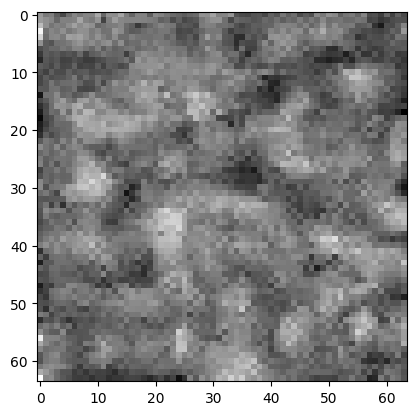

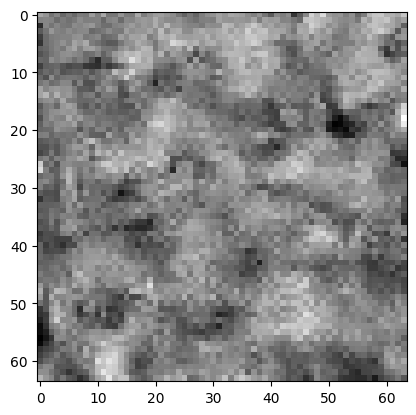

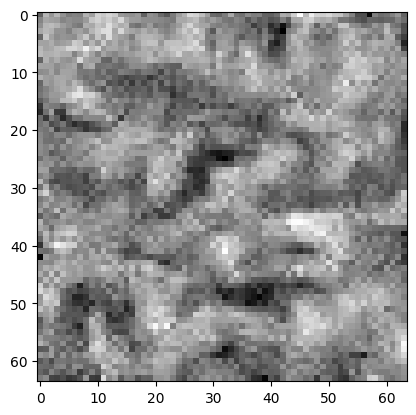

Epoch 2 : 


100%|██████████| 400/400 [00:19<00:00, 20.84it/s]


loss 0.2266892143467238
Epoch 3 : 


100%|██████████| 400/400 [00:19<00:00, 20.76it/s]


loss 0.32625289919864914
Epoch 4 : 


100%|██████████| 400/400 [00:19<00:00, 20.99it/s]


loss 0.2620026577508809
Epoch 5 : 


100%|██████████| 400/400 [00:18<00:00, 21.55it/s]


loss 0.25272093977545534
Epoch 6 : 


100%|██████████| 400/400 [00:18<00:00, 22.03it/s]


loss 0.22673903540735274
Epoch 7 : 


100%|██████████| 400/400 [00:18<00:00, 21.52it/s]


loss 0.3294394018983879
Epoch 8 : 


100%|██████████| 400/400 [00:18<00:00, 21.10it/s]


loss 0.3132746297812932
Epoch 9 : 


100%|██████████| 400/400 [00:19<00:00, 20.56it/s]


loss 0.29539498629640326
Epoch 10 : 


100%|██████████| 400/400 [00:19<00:00, 21.03it/s]


loss 0.24696238433978548
Epoch 11 : 


100%|██████████| 400/400 [00:18<00:00, 21.34it/s]


loss 0.3136755847328296
Epoch 12 : 


100%|██████████| 400/400 [00:18<00:00, 21.12it/s]


loss 0.20980701925526668
Epoch 13 : 


100%|██████████| 400/400 [00:18<00:00, 21.15it/s]


loss 0.2903609547360054
Epoch 14 : 


100%|██████████| 400/400 [00:17<00:00, 22.62it/s]


loss 0.32288234687383927
Epoch 15 : 


100%|██████████| 400/400 [00:18<00:00, 21.44it/s]


loss 0.2272254828387118
Epoch 16 : 


100%|██████████| 400/400 [00:19<00:00, 20.87it/s]


loss 0.2728676926423576
Epoch 17 : 


100%|██████████| 400/400 [00:18<00:00, 21.64it/s]


loss 0.21773802589923952
Epoch 18 : 


100%|██████████| 400/400 [00:19<00:00, 21.04it/s]


loss 0.2360964852411397
Epoch 19 : 


100%|██████████| 400/400 [00:18<00:00, 21.18it/s]


loss 0.31095042295420944
Epoch 20 : 


100%|██████████| 400/400 [00:20<00:00, 19.30it/s]


loss 0.25747147873601106
Epoch 21 : 


100%|██████████| 400/400 [00:21<00:00, 18.94it/s]


loss 0.3328456963361889
torch.Size([3, 1, 64, 64])


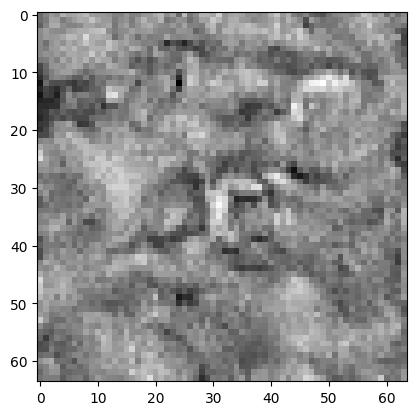

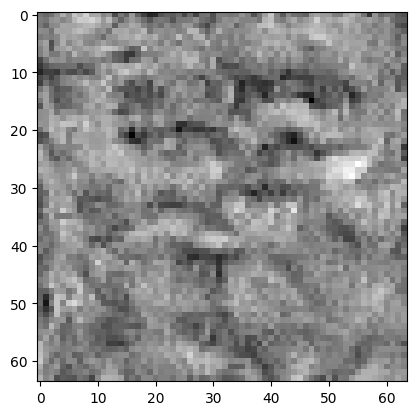

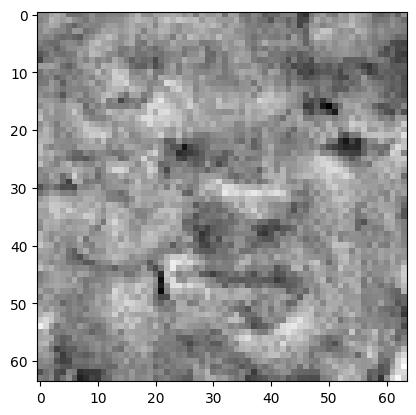

Epoch 22 : 


100%|██████████| 400/400 [00:21<00:00, 18.85it/s]


loss 0.2751267899135568
Epoch 23 : 


100%|██████████| 400/400 [00:20<00:00, 19.10it/s]


loss 0.21201910931701898
Epoch 24 : 


100%|██████████| 400/400 [00:21<00:00, 18.64it/s]


loss 0.24431251228364062
Epoch 25 : 


100%|██████████| 400/400 [00:20<00:00, 19.14it/s]


loss 0.24842180134443875
Epoch 26 : 


100%|██████████| 400/400 [00:21<00:00, 18.31it/s]


loss 0.2300141312529387
Epoch 27 : 


100%|██████████| 400/400 [00:21<00:00, 18.56it/s]


loss 0.2255871858318408
Epoch 28 : 


100%|██████████| 400/400 [00:21<00:00, 18.72it/s]


loss 0.20543898101834018
Epoch 29 : 


100%|██████████| 400/400 [00:21<00:00, 18.93it/s]


loss 0.26992043635193863
Epoch 30 : 


100%|██████████| 400/400 [00:21<00:00, 18.71it/s]


loss 0.20407888728164103
Epoch 31 : 


100%|██████████| 400/400 [00:21<00:00, 18.89it/s]


loss 0.34938172244570004
Epoch 32 : 


100%|██████████| 400/400 [00:20<00:00, 19.23it/s]


loss 0.29106272415362905
Epoch 33 : 


100%|██████████| 400/400 [00:20<00:00, 19.79it/s]


loss 0.2897994888161076
Epoch 34 : 


100%|██████████| 400/400 [00:20<00:00, 19.08it/s]


loss 0.21198303418005343
Epoch 35 : 


100%|██████████| 400/400 [00:20<00:00, 19.64it/s]


loss 0.23545769398125424
Epoch 36 : 


100%|██████████| 400/400 [00:18<00:00, 21.18it/s]


loss 0.19767013550887916
Epoch 37 : 


100%|██████████| 400/400 [00:18<00:00, 21.06it/s]


loss 0.24674125912174272
Epoch 38 : 


100%|██████████| 400/400 [00:19<00:00, 20.50it/s]


loss 0.21462363605619716
Epoch 39 : 


100%|██████████| 400/400 [00:18<00:00, 21.19it/s]


loss 0.23579898888616313
Epoch 40 : 


100%|██████████| 400/400 [00:17<00:00, 22.74it/s]


loss 0.20653857041165435
Epoch 41 : 


100%|██████████| 400/400 [00:13<00:00, 28.96it/s]


loss 0.333827480643318
torch.Size([3, 1, 64, 64])


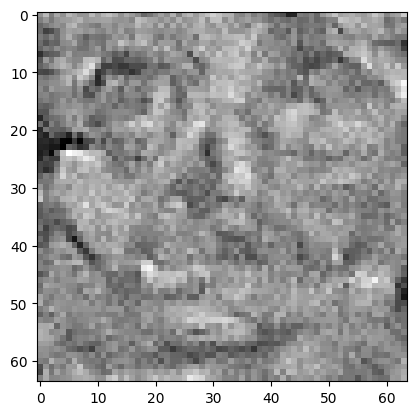

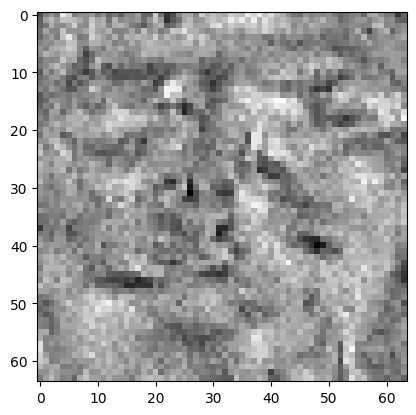

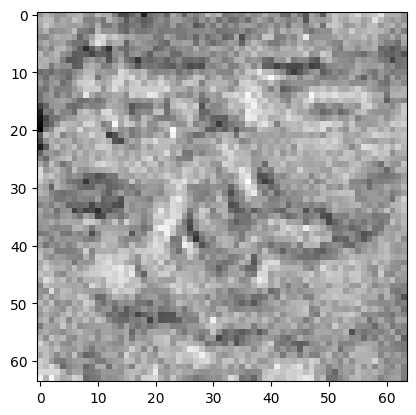

Epoch 42 : 


100%|██████████| 400/400 [00:17<00:00, 23.43it/s]


loss 0.26833473174633105
Epoch 43 : 


100%|██████████| 400/400 [00:17<00:00, 22.54it/s]


loss 0.2676242177271297
Epoch 44 : 


100%|██████████| 400/400 [00:16<00:00, 23.53it/s]


loss 0.26940293431845647
Epoch 45 : 


100%|██████████| 400/400 [00:19<00:00, 20.92it/s]


loss 0.25320972003604836
Epoch 46 : 


100%|██████████| 400/400 [00:20<00:00, 19.15it/s]


loss 0.23617799307270518
Epoch 47 : 


100%|██████████| 400/400 [00:21<00:00, 19.04it/s]


loss 0.2335294380201557
Epoch 48 : 


100%|██████████| 400/400 [00:21<00:00, 18.96it/s]


loss 0.28282534043295493
Epoch 49 : 


100%|██████████| 400/400 [00:21<00:00, 19.02it/s]


loss 0.22451839410167557
Epoch 50 : 


100%|██████████| 400/400 [00:21<00:00, 18.94it/s]


loss 0.21752797270956228
Epoch 51 : 


100%|██████████| 400/400 [00:19<00:00, 20.18it/s]


loss 0.1880008622645862
Epoch 52 : 


100%|██████████| 400/400 [00:21<00:00, 18.88it/s]


loss 0.2822797182844019
Epoch 53 : 


100%|██████████| 400/400 [00:20<00:00, 19.14it/s]


loss 0.20663770468265388
Epoch 54 : 


100%|██████████| 400/400 [00:21<00:00, 18.59it/s]


loss 0.2925750766023834
Epoch 55 : 


100%|██████████| 400/400 [00:21<00:00, 18.73it/s]


loss 0.21973899042284956
Epoch 56 : 


100%|██████████| 400/400 [00:21<00:00, 18.29it/s]


loss 0.28613772516146746
Epoch 57 : 


100%|██████████| 400/400 [00:21<00:00, 18.99it/s]


loss 0.18773385386168828
Epoch 58 : 


100%|██████████| 400/400 [00:22<00:00, 18.10it/s]


loss 0.18609642945866514
Epoch 59 : 


100%|██████████| 400/400 [00:22<00:00, 18.18it/s]


loss 0.19016985011946658
Epoch 60 : 


100%|██████████| 400/400 [00:21<00:00, 18.86it/s]


loss 0.20306276781372448
Epoch 61 : 


100%|██████████| 400/400 [00:21<00:00, 18.94it/s]


loss 0.2501357208197091
torch.Size([3, 1, 64, 64])


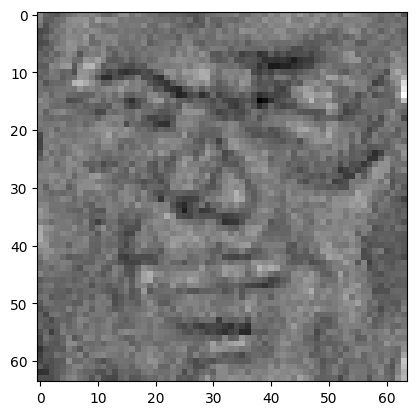

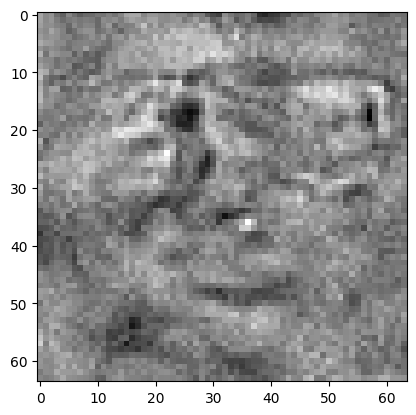

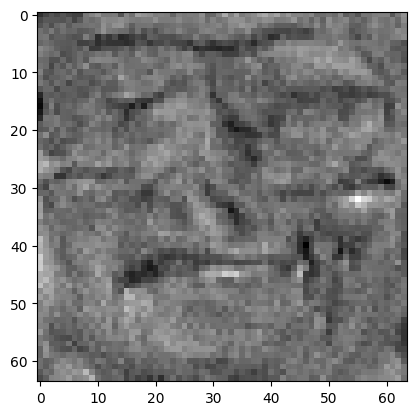

Epoch 62 : 


100%|██████████| 400/400 [00:21<00:00, 18.85it/s]


loss 0.21086787183496436
Epoch 63 : 


100%|██████████| 400/400 [00:21<00:00, 18.48it/s]


loss 0.27874462784456555
Epoch 64 : 


100%|██████████| 400/400 [00:21<00:00, 18.76it/s]


loss 0.2591030460308521
Epoch 65 : 


100%|██████████| 400/400 [00:22<00:00, 18.05it/s]


loss 0.21029885210349591
Epoch 66 : 


100%|██████████| 400/400 [00:21<00:00, 18.43it/s]


loss 0.17517336314194198
Epoch 67 : 


100%|██████████| 400/400 [00:21<00:00, 18.83it/s]


loss 0.24671225286322118
Epoch 68 : 


100%|██████████| 400/400 [00:22<00:00, 17.60it/s]


loss 0.20037197600449613
Epoch 69 : 


100%|██████████| 400/400 [00:20<00:00, 19.37it/s]


loss 0.21980841475284854
Epoch 70 : 


100%|██████████| 400/400 [00:21<00:00, 18.40it/s]


loss 0.24356375269912095
Epoch 71 : 


100%|██████████| 400/400 [00:20<00:00, 19.64it/s]


loss 0.20310063440699033
Epoch 72 : 


100%|██████████| 400/400 [00:12<00:00, 32.72it/s]


loss 0.2372975284807123
Epoch 73 : 


100%|██████████| 400/400 [00:19<00:00, 20.73it/s]


loss 0.23209413181722233
Epoch 74 : 


100%|██████████| 400/400 [00:19<00:00, 20.56it/s]


loss 0.23347754783182445
Epoch 75 : 


100%|██████████| 400/400 [00:21<00:00, 18.97it/s]


loss 0.21507076613269954
Epoch 76 : 


100%|██████████| 400/400 [00:21<00:00, 18.25it/s]


loss 0.2543325088484922
Epoch 77 : 


100%|██████████| 400/400 [00:19<00:00, 20.51it/s]


loss 0.32342425472749253
Epoch 78 : 


100%|██████████| 400/400 [00:20<00:00, 19.58it/s]


loss 0.23167929975039064
Epoch 79 : 


100%|██████████| 400/400 [00:21<00:00, 18.60it/s]


loss 0.27209732783362595
Epoch 80 : 


100%|██████████| 400/400 [00:21<00:00, 18.84it/s]


loss 0.18953075612245077
Epoch 81 : 


100%|██████████| 400/400 [00:20<00:00, 19.66it/s]


loss 0.2535385706078758
torch.Size([3, 1, 64, 64])


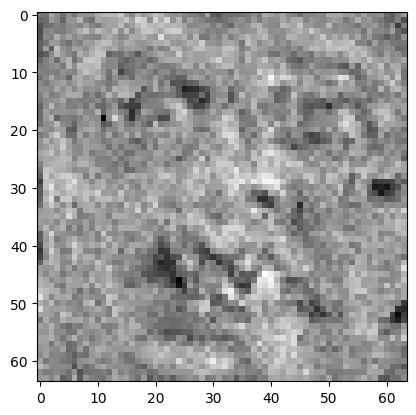

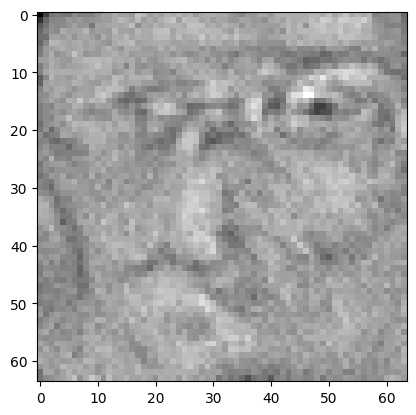

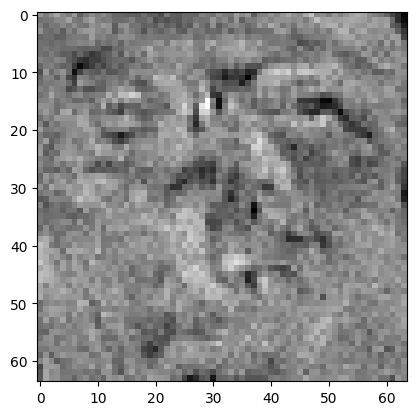

Epoch 82 : 


100%|██████████| 400/400 [00:21<00:00, 18.81it/s]


loss 0.27117182672107926
Epoch 83 : 


100%|██████████| 400/400 [00:21<00:00, 19.02it/s]


loss 0.1735582463816993
Epoch 84 : 


100%|██████████| 400/400 [00:20<00:00, 19.43it/s]


loss 0.20655064762288425
Epoch 85 : 


100%|██████████| 400/400 [00:21<00:00, 18.82it/s]


loss 0.24984606002317955
Epoch 86 : 


100%|██████████| 400/400 [00:20<00:00, 19.44it/s]


loss 0.24056658721568203
Epoch 87 : 


100%|██████████| 400/400 [00:17<00:00, 22.38it/s]


loss 0.25126527483984273
Epoch 88 : 


100%|██████████| 400/400 [00:20<00:00, 19.17it/s]


loss 0.17607495963252423
Epoch 89 : 


100%|██████████| 400/400 [00:21<00:00, 18.92it/s]


loss 0.21378942948633062
Epoch 90 : 


100%|██████████| 400/400 [00:21<00:00, 18.69it/s]


loss 0.23700405171886332
Epoch 91 : 


100%|██████████| 400/400 [00:21<00:00, 18.75it/s]


loss 0.27330598740462253
Epoch 92 : 


100%|██████████| 400/400 [00:20<00:00, 19.47it/s]


loss 0.20077490899512307
Epoch 93 : 


100%|██████████| 400/400 [00:20<00:00, 19.62it/s]


loss 0.2964217015727888
Epoch 94 : 


100%|██████████| 400/400 [00:20<00:00, 19.51it/s]


loss 0.25287771244508933
Epoch 95 : 


100%|██████████| 400/400 [00:21<00:00, 18.75it/s]


loss 0.29046807395722
Epoch 96 : 


100%|██████████| 400/400 [00:21<00:00, 18.81it/s]


loss 0.17816860679010735
Epoch 97 : 


100%|██████████| 400/400 [00:21<00:00, 18.92it/s]


loss 0.2891332004386893
Epoch 98 : 


100%|██████████| 400/400 [00:20<00:00, 19.23it/s]


loss 0.21874173325742619
Epoch 99 : 


100%|██████████| 400/400 [00:20<00:00, 19.52it/s]


loss 0.2795323765123569


In [13]:
train_ddpm(100, 0.001, 1, 0.0000)

Epoch 0 : 


100%|██████████| 400/400 [00:20<00:00, 19.16it/s]


loss 0.17301766832719717
Epoch 1 : 


100%|██████████| 400/400 [00:20<00:00, 19.05it/s]


loss 0.2877638266076878
torch.Size([3, 1, 64, 64])


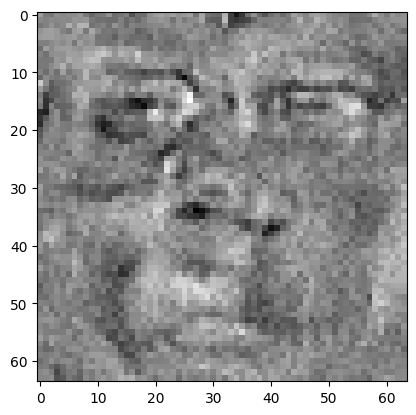

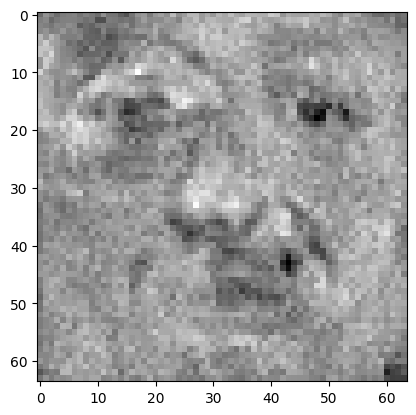

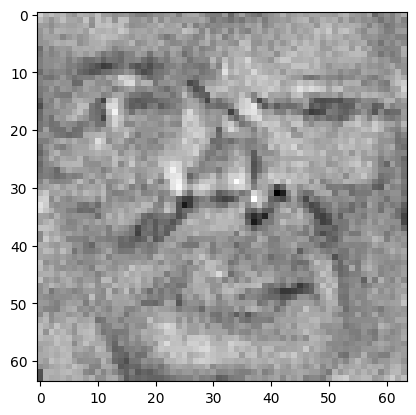

Epoch 2 : 


100%|██████████| 400/400 [00:21<00:00, 18.94it/s]


loss 0.23932994430996826
Epoch 3 : 


100%|██████████| 400/400 [00:21<00:00, 18.68it/s]


loss 0.1655955749478949
Epoch 4 : 


100%|██████████| 400/400 [00:21<00:00, 18.94it/s]


loss 0.20730874584895043
Epoch 5 : 


100%|██████████| 400/400 [00:21<00:00, 18.93it/s]


loss 0.26205280479740845
Epoch 6 : 


100%|██████████| 400/400 [00:21<00:00, 18.82it/s]


loss 0.20729116428820316
Epoch 7 : 


100%|██████████| 400/400 [00:19<00:00, 20.68it/s]


loss 0.21930384310812367
Epoch 8 : 


100%|██████████| 400/400 [00:19<00:00, 20.14it/s]


loss 0.17033394804112836
Epoch 9 : 


100%|██████████| 400/400 [00:18<00:00, 21.57it/s]


loss 0.22602124892226824
Epoch 10 : 


100%|██████████| 400/400 [00:20<00:00, 19.69it/s]


loss 0.27723670388470645
Epoch 11 : 


100%|██████████| 400/400 [00:21<00:00, 18.89it/s]


loss 0.2576549888443589
Epoch 12 : 


100%|██████████| 400/400 [00:20<00:00, 19.17it/s]


loss 0.23825701261384008
Epoch 13 : 


100%|██████████| 400/400 [00:21<00:00, 18.88it/s]


loss 0.25227196538500785
Epoch 14 : 


100%|██████████| 400/400 [00:21<00:00, 19.02it/s]


loss 0.15073403367343813
Epoch 15 : 


100%|██████████| 400/400 [00:21<00:00, 18.76it/s]


loss 0.22330472763743595
Epoch 16 : 


100%|██████████| 400/400 [00:21<00:00, 18.85it/s]


loss 0.2592055989377866
Epoch 17 : 


100%|██████████| 400/400 [00:21<00:00, 18.98it/s]


loss 0.152910469299995
Epoch 18 : 


100%|██████████| 400/400 [00:20<00:00, 19.71it/s]


loss 0.2110112896830231
Epoch 19 : 


100%|██████████| 400/400 [00:20<00:00, 19.06it/s]


loss 0.22084071857038093
Epoch 20 : 


100%|██████████| 400/400 [00:21<00:00, 18.65it/s]


loss 0.2444504414668117
Epoch 21 : 


100%|██████████| 400/400 [00:20<00:00, 19.12it/s]


loss 0.2079310078784476
torch.Size([3, 1, 64, 64])


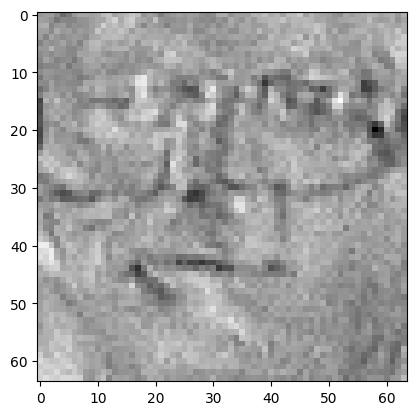

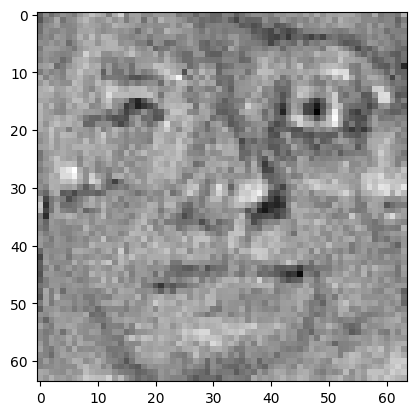

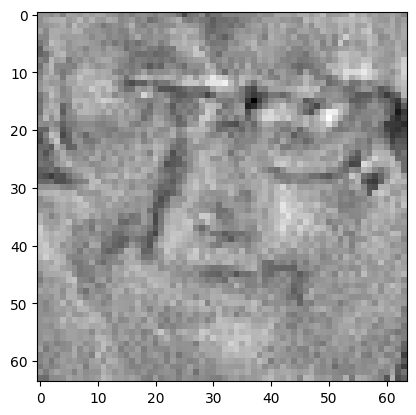

Epoch 22 : 


100%|██████████| 400/400 [00:21<00:00, 18.90it/s]


loss 0.16135147569521957
Epoch 23 : 


100%|██████████| 400/400 [00:20<00:00, 19.12it/s]


loss 0.21972728958096194
Epoch 24 : 


100%|██████████| 400/400 [00:20<00:00, 19.26it/s]


loss 0.21920746083738094
Epoch 25 : 


100%|██████████| 400/400 [00:20<00:00, 19.45it/s]


loss 0.19027916959131608
Epoch 26 : 


100%|██████████| 400/400 [00:21<00:00, 18.78it/s]


loss 0.2260693485383694
Epoch 27 : 


100%|██████████| 400/400 [00:20<00:00, 19.58it/s]


loss 0.22384544676861273
Epoch 28 : 


100%|██████████| 400/400 [00:20<00:00, 19.51it/s]


loss 0.18706260556645232
Epoch 29 : 


100%|██████████| 400/400 [00:21<00:00, 18.76it/s]


loss 0.14520505046289797
Epoch 30 : 


100%|██████████| 400/400 [00:21<00:00, 18.55it/s]


loss 0.2723425015440255
Epoch 31 : 


100%|██████████| 400/400 [00:20<00:00, 19.16it/s]


loss 0.18413298341259307
Epoch 32 : 


100%|██████████| 400/400 [00:21<00:00, 19.02it/s]


loss 0.18878479895386807
Epoch 33 : 


100%|██████████| 400/400 [00:21<00:00, 18.96it/s]


loss 0.18747297443889105
Epoch 34 : 


100%|██████████| 400/400 [00:20<00:00, 19.07it/s]


loss 0.2840935447014771
Epoch 35 : 


100%|██████████| 400/400 [00:20<00:00, 19.66it/s]


loss 0.2202969939863999
Epoch 36 : 


100%|██████████| 400/400 [00:20<00:00, 19.40it/s]


loss 0.19375322650025267
Epoch 37 : 


100%|██████████| 400/400 [00:21<00:00, 18.79it/s]


loss 0.22862263209449984
Epoch 38 : 


100%|██████████| 400/400 [00:20<00:00, 19.11it/s]


loss 0.17161393226753296
Epoch 39 : 


100%|██████████| 400/400 [00:20<00:00, 19.42it/s]


loss 0.206184994675285
Epoch 40 : 


100%|██████████| 400/400 [00:20<00:00, 19.31it/s]


loss 0.19138464267253444
Epoch 41 : 


100%|██████████| 400/400 [00:21<00:00, 18.46it/s]


loss 0.24614151212687813
torch.Size([3, 1, 64, 64])


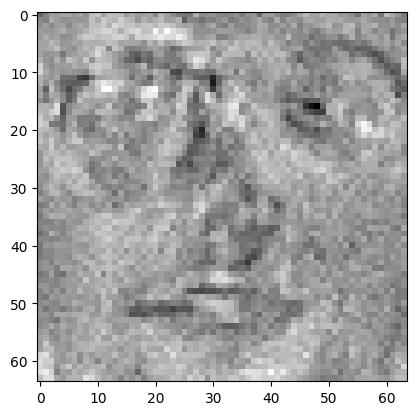

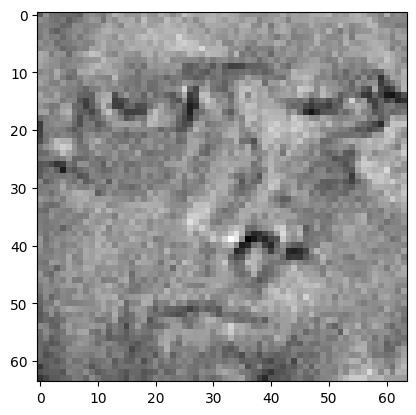

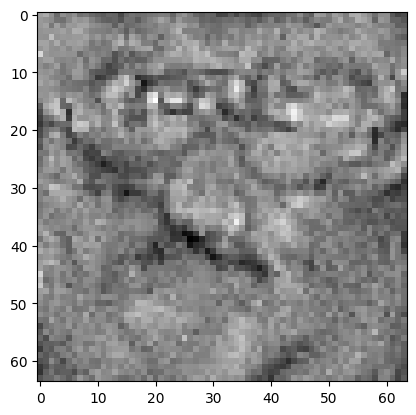

Epoch 42 : 


100%|██████████| 400/400 [00:21<00:00, 18.78it/s]


loss 0.15178739011193926
Epoch 43 : 


100%|██████████| 400/400 [00:20<00:00, 19.15it/s]


loss 0.16206877995019478
Epoch 44 : 


100%|██████████| 400/400 [00:20<00:00, 19.05it/s]


loss 0.20704689717180097
Epoch 45 : 


100%|██████████| 400/400 [00:20<00:00, 19.35it/s]


loss 0.28450271699260105
Epoch 46 : 


100%|██████████| 400/400 [00:21<00:00, 18.91it/s]


loss 0.34043592573063397
Epoch 47 : 


100%|██████████| 400/400 [00:21<00:00, 18.99it/s]


loss 0.30182366392563276
Epoch 48 : 


100%|██████████| 400/400 [00:21<00:00, 18.89it/s]


loss 0.19267716008391916
Epoch 49 : 


100%|██████████| 400/400 [00:20<00:00, 19.17it/s]


loss 0.20228563950815462
Epoch 50 : 


100%|██████████| 400/400 [00:20<00:00, 19.13it/s]


loss 0.20653907069897923
Epoch 51 : 


100%|██████████| 400/400 [00:21<00:00, 18.72it/s]


loss 0.19691571277412515
Epoch 52 : 


100%|██████████| 400/400 [00:21<00:00, 18.92it/s]


loss 0.2008198546631491
Epoch 53 : 


100%|██████████| 400/400 [00:20<00:00, 19.18it/s]


loss 0.24096155914135434
Epoch 54 : 


100%|██████████| 400/400 [00:20<00:00, 19.23it/s]


loss 0.2273666870143984
Epoch 55 : 


100%|██████████| 400/400 [00:20<00:00, 19.12it/s]


loss 0.19994153298997994
Epoch 56 : 


100%|██████████| 400/400 [00:20<00:00, 19.26it/s]


loss 0.19143425032188735
Epoch 57 : 


100%|██████████| 400/400 [00:20<00:00, 19.64it/s]


loss 0.17853074088067925
Epoch 58 : 


100%|██████████| 400/400 [00:21<00:00, 18.93it/s]


loss 0.23009318649613134
Epoch 59 : 


100%|██████████| 400/400 [00:21<00:00, 18.67it/s]


loss 0.22047340184337197
Epoch 60 : 


100%|██████████| 400/400 [00:19<00:00, 20.50it/s]


loss 0.24638260713769544
Epoch 61 : 


100%|██████████| 400/400 [00:19<00:00, 20.78it/s]


loss 0.1614631299496041
torch.Size([3, 1, 64, 64])


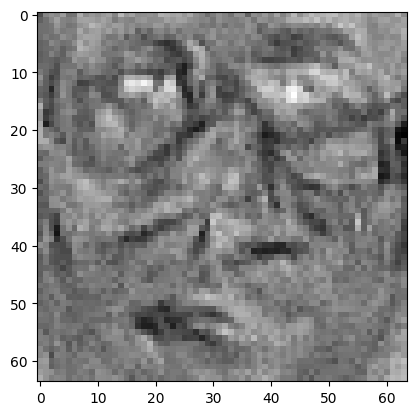

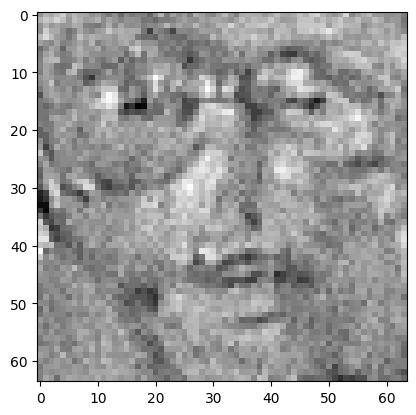

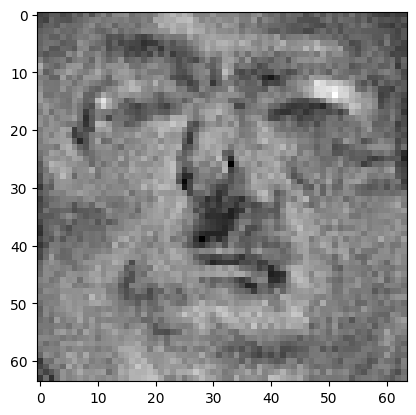

Epoch 62 : 


100%|██████████| 400/400 [00:19<00:00, 20.24it/s]


loss 0.23115394101427883
Epoch 63 : 


100%|██████████| 400/400 [00:19<00:00, 20.76it/s]


loss 0.20706088108402457
Epoch 64 : 


100%|██████████| 400/400 [00:19<00:00, 20.61it/s]


loss 0.24400059653530715
Epoch 65 : 


100%|██████████| 400/400 [00:20<00:00, 19.86it/s]


loss 0.24667840885525597
Epoch 66 : 


100%|██████████| 400/400 [00:20<00:00, 19.58it/s]


loss 0.1796312400196487
Epoch 67 : 


100%|██████████| 400/400 [00:20<00:00, 19.48it/s]


loss 0.18135093123388119
Epoch 68 : 


100%|██████████| 400/400 [00:20<00:00, 19.27it/s]


loss 0.22550857157716891
Epoch 69 : 


100%|██████████| 400/400 [00:20<00:00, 19.36it/s]


loss 0.2004283744875131
Epoch 70 : 


100%|██████████| 400/400 [00:20<00:00, 19.32it/s]


loss 0.20738621342987096
Epoch 71 : 


100%|██████████| 400/400 [00:21<00:00, 18.81it/s]


loss 0.2179021612803767
Epoch 72 : 


100%|██████████| 400/400 [00:20<00:00, 19.14it/s]


loss 0.20600254568643178
Epoch 73 : 


100%|██████████| 400/400 [00:21<00:00, 18.92it/s]


loss 0.2117613419854397
Epoch 74 : 


100%|██████████| 400/400 [00:21<00:00, 18.60it/s]


loss 0.1669330891410873
Epoch 75 : 


100%|██████████| 400/400 [00:20<00:00, 19.33it/s]


loss 0.2622304774285571
Epoch 76 : 


100%|██████████| 400/400 [00:20<00:00, 19.66it/s]


loss 0.19970315449183373
Epoch 77 : 


100%|██████████| 400/400 [00:21<00:00, 18.92it/s]


loss 0.21661353334535918
Epoch 78 : 


100%|██████████| 400/400 [00:20<00:00, 19.31it/s]


loss 0.20373396589823545
Epoch 79 : 


100%|██████████| 400/400 [00:20<00:00, 19.23it/s]


loss 0.21393553063650683
Epoch 80 : 


100%|██████████| 400/400 [00:21<00:00, 18.93it/s]


loss 0.1914515166799903
Epoch 81 : 


100%|██████████| 400/400 [00:20<00:00, 19.11it/s]


loss 0.30937152137690194
torch.Size([3, 1, 64, 64])


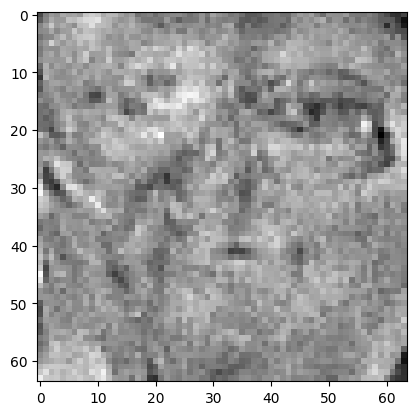

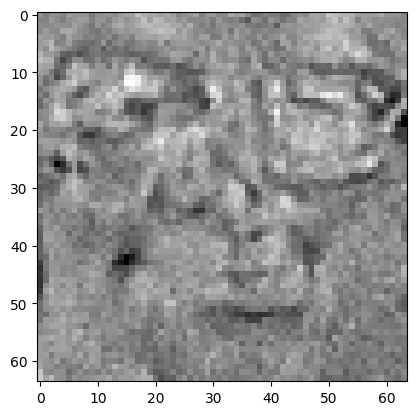

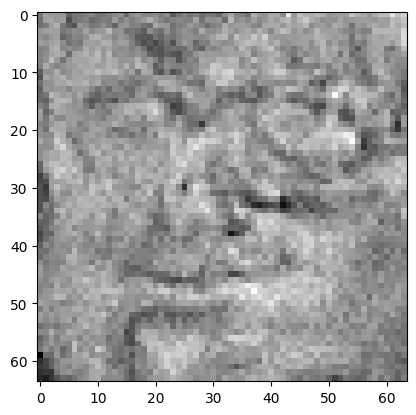

Epoch 82 : 


100%|██████████| 400/400 [00:20<00:00, 19.44it/s]


loss 0.21731528249180596
Epoch 83 : 


100%|██████████| 400/400 [00:20<00:00, 19.10it/s]


loss 0.17781651514415256
Epoch 84 : 


100%|██████████| 400/400 [00:20<00:00, 19.29it/s]


loss 0.18589903823733078
Epoch 85 : 


100%|██████████| 400/400 [00:20<00:00, 19.07it/s]


loss 0.2469726797779493
Epoch 86 : 


100%|██████████| 400/400 [00:20<00:00, 19.51it/s]


loss 0.18008925954029018
Epoch 87 : 


100%|██████████| 400/400 [00:20<00:00, 19.40it/s]


loss 0.2238006332734562
Epoch 88 : 


100%|██████████| 400/400 [00:21<00:00, 18.77it/s]


loss 0.15768581604230225
Epoch 89 : 


100%|██████████| 400/400 [00:20<00:00, 19.26it/s]


loss 0.22469006961443566
Epoch 90 : 


100%|██████████| 400/400 [00:21<00:00, 18.89it/s]


loss 0.2579648705266297
Epoch 91 : 


100%|██████████| 400/400 [00:20<00:00, 19.78it/s]


loss 0.22643730642685592
Epoch 92 : 


100%|██████████| 400/400 [00:21<00:00, 18.98it/s]


loss 0.276515602140273
Epoch 93 : 


100%|██████████| 400/400 [00:20<00:00, 19.33it/s]


loss 0.1794990968754334
Epoch 94 : 


100%|██████████| 400/400 [00:20<00:00, 19.28it/s]


loss 0.22297925782613165
Epoch 95 : 


100%|██████████| 400/400 [00:20<00:00, 19.09it/s]


loss 0.20396493466783128
Epoch 96 : 


100%|██████████| 400/400 [00:20<00:00, 19.58it/s]


loss 0.3060090818250323
Epoch 97 : 


100%|██████████| 400/400 [00:20<00:00, 19.13it/s]


loss 0.22242375754767463
Epoch 98 : 


100%|██████████| 400/400 [00:21<00:00, 18.69it/s]


loss 0.1865172512204158
Epoch 99 : 


100%|██████████| 400/400 [00:20<00:00, 19.20it/s]


loss 0.17923411066144257


In [14]:
train_ddpm(100, 0.0001, 1, 0.0000)

Epoch 0 : 


100%|██████████| 400/400 [00:20<00:00, 19.08it/s]


loss 0.24182092789884618
Epoch 1 : 


100%|██████████| 400/400 [00:21<00:00, 19.02it/s]


loss 0.20598467777686863
torch.Size([3, 1, 64, 64])


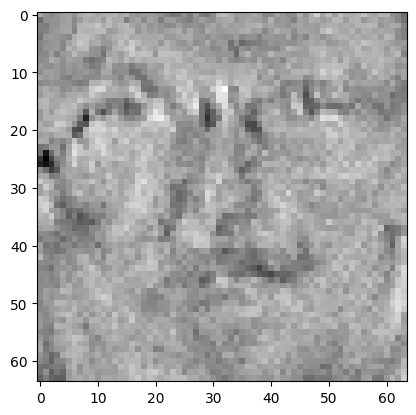

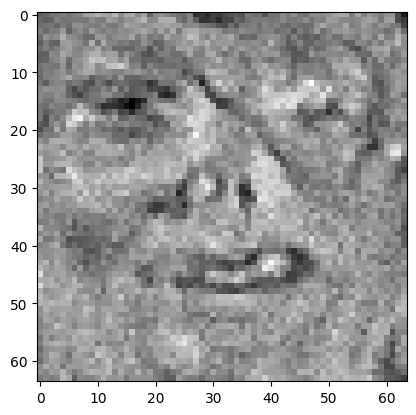

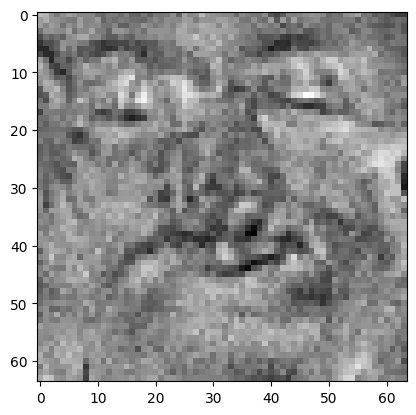

Epoch 2 : 


100%|██████████| 400/400 [00:20<00:00, 19.69it/s]


loss 0.29391163538362525
Epoch 3 : 


100%|██████████| 400/400 [00:21<00:00, 19.00it/s]


loss 0.24773241600145324
Epoch 4 : 


100%|██████████| 400/400 [00:20<00:00, 19.11it/s]


loss 0.17337750663787413
Epoch 5 : 


100%|██████████| 400/400 [00:21<00:00, 19.03it/s]


loss 0.15739259266270672
Epoch 6 : 


100%|██████████| 400/400 [00:21<00:00, 18.62it/s]


loss 0.2737066251938884
Epoch 7 : 


100%|██████████| 400/400 [00:21<00:00, 18.99it/s]


loss 0.23310267146527655
Epoch 8 : 


100%|██████████| 400/400 [00:20<00:00, 19.29it/s]


loss 0.22863014982609842
Epoch 9 : 


100%|██████████| 400/400 [00:20<00:00, 19.39it/s]


loss 0.20474646444233374
Epoch 10 : 


100%|██████████| 400/400 [00:21<00:00, 18.85it/s]


loss 0.20962042722453114
Epoch 11 : 


100%|██████████| 400/400 [00:19<00:00, 20.04it/s]


loss 0.24263790298683668
Epoch 12 : 


100%|██████████| 400/400 [00:21<00:00, 18.99it/s]


loss 0.2824129411801557
Epoch 13 : 


100%|██████████| 400/400 [00:20<00:00, 19.15it/s]


loss 0.15636740591212875
Epoch 14 : 


100%|██████████| 400/400 [00:20<00:00, 19.43it/s]


loss 0.21647281855492495
Epoch 15 : 


100%|██████████| 400/400 [00:20<00:00, 19.52it/s]


loss 0.27363347009008104
Epoch 16 : 


100%|██████████| 400/400 [00:20<00:00, 19.26it/s]


loss 0.2427331157908273
Epoch 17 : 


100%|██████████| 400/400 [00:19<00:00, 20.05it/s]


loss 0.2380254457698752
Epoch 18 : 


100%|██████████| 400/400 [00:20<00:00, 19.30it/s]


loss 0.28206766300957703
Epoch 19 : 


100%|██████████| 400/400 [00:20<00:00, 19.52it/s]


loss 0.2529616104549409
Epoch 20 : 


100%|██████████| 400/400 [00:20<00:00, 19.46it/s]


loss 0.2945216274326763
Epoch 21 : 


100%|██████████| 400/400 [00:20<00:00, 19.74it/s]


loss 0.1779385733147447
torch.Size([3, 1, 64, 64])


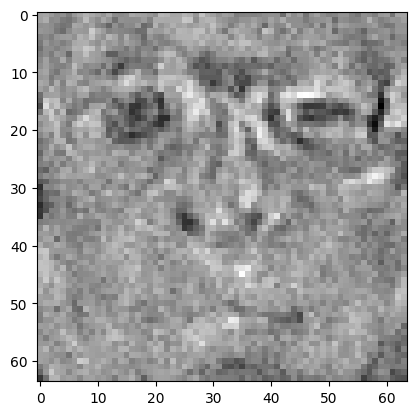

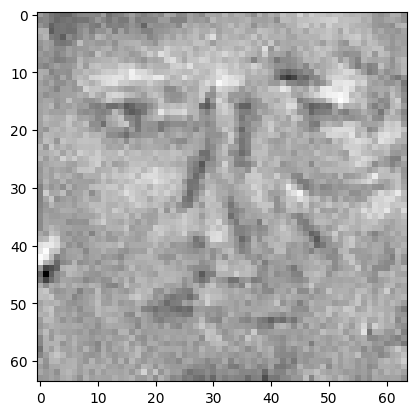

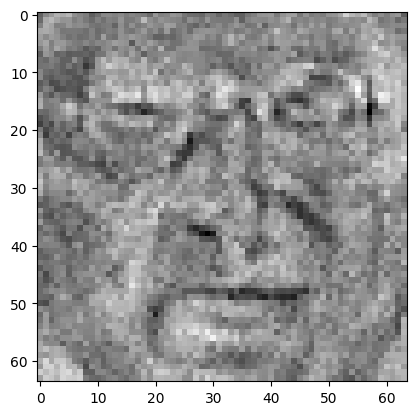

Epoch 22 : 


100%|██████████| 400/400 [00:20<00:00, 19.09it/s]


loss 0.17683810779259534
Epoch 23 : 


100%|██████████| 400/400 [00:21<00:00, 19.03it/s]


loss 0.1957946355571895
Epoch 24 : 


100%|██████████| 400/400 [00:20<00:00, 19.39it/s]


loss 0.18296875470553334
Epoch 25 : 


100%|██████████| 400/400 [00:20<00:00, 19.23it/s]


loss 0.22043495421698622
Epoch 26 : 


100%|██████████| 400/400 [00:20<00:00, 19.06it/s]


loss 0.23047370679667167
Epoch 27 : 


100%|██████████| 400/400 [00:20<00:00, 19.19it/s]


loss 0.31294597788452994
Epoch 28 : 


100%|██████████| 400/400 [00:20<00:00, 19.71it/s]


loss 0.18860463870801064
Epoch 29 : 


100%|██████████| 400/400 [00:20<00:00, 19.46it/s]


loss 0.19738889739550508
Epoch 30 : 


100%|██████████| 400/400 [00:20<00:00, 19.26it/s]


loss 0.24705644102551014
Epoch 31 : 


100%|██████████| 400/400 [00:20<00:00, 19.28it/s]


loss 0.1760594980283524
Epoch 32 : 


100%|██████████| 400/400 [00:20<00:00, 19.71it/s]


loss 0.1841780439402536
Epoch 33 : 


100%|██████████| 400/400 [00:20<00:00, 19.35it/s]


loss 0.23426088173463333
Epoch 34 : 


100%|██████████| 400/400 [00:20<00:00, 19.32it/s]


loss 0.28417160333952785
Epoch 35 : 


100%|██████████| 400/400 [00:21<00:00, 18.76it/s]


loss 0.19762939033330046
Epoch 36 : 


100%|██████████| 400/400 [00:20<00:00, 19.48it/s]


loss 0.22777786082793416
Epoch 37 : 


100%|██████████| 400/400 [00:20<00:00, 19.13it/s]


loss 0.24685297256310773
Epoch 38 : 


100%|██████████| 400/400 [00:20<00:00, 19.25it/s]


loss 0.19114779250957506
Epoch 39 : 


100%|██████████| 400/400 [00:20<00:00, 19.26it/s]


loss 0.19738969508699453
Epoch 40 : 


100%|██████████| 400/400 [00:20<00:00, 19.34it/s]


loss 0.17049863666949377
Epoch 41 : 


100%|██████████| 400/400 [00:20<00:00, 19.57it/s]


loss 0.20775217560468673
torch.Size([3, 1, 64, 64])


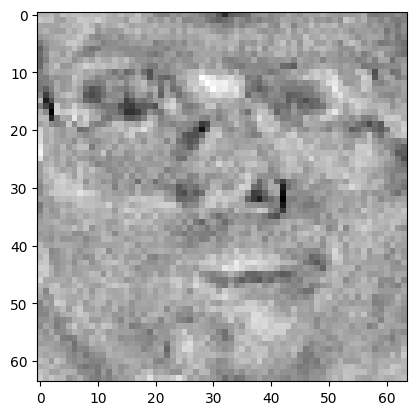

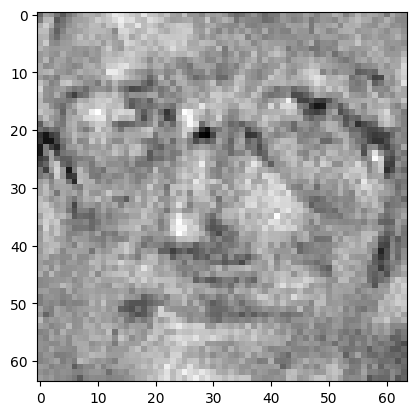

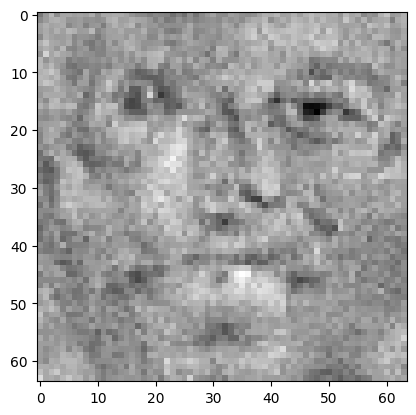

Epoch 42 : 


100%|██████████| 400/400 [00:20<00:00, 19.58it/s]


loss 0.16963319332232016
Epoch 43 : 


100%|██████████| 400/400 [00:20<00:00, 19.21it/s]


loss 0.25998534494324266
Epoch 44 : 


100%|██████████| 400/400 [00:21<00:00, 18.44it/s]


loss 0.26289831812678444
Epoch 45 : 


100%|██████████| 400/400 [00:21<00:00, 18.77it/s]


loss 0.2016329366448502
Epoch 46 : 


100%|██████████| 400/400 [00:20<00:00, 19.95it/s]


loss 0.1998131149686009
Epoch 47 : 


100%|██████████| 400/400 [00:20<00:00, 19.78it/s]


loss 0.1824713667937005
Epoch 48 : 


100%|██████████| 400/400 [00:20<00:00, 19.19it/s]


loss 0.1714519291087423
Epoch 49 : 


100%|██████████| 400/400 [00:21<00:00, 18.98it/s]


loss 0.23491204549832362
Epoch 50 : 


100%|██████████| 400/400 [00:20<00:00, 19.77it/s]


loss 0.19735206220132578
Epoch 51 : 


100%|██████████| 400/400 [00:20<00:00, 19.10it/s]


loss 0.18463716438763747
Epoch 52 : 


100%|██████████| 400/400 [00:20<00:00, 19.78it/s]


loss 0.1813119827353657
Epoch 53 : 


100%|██████████| 400/400 [00:21<00:00, 18.37it/s]


loss 0.2519601373545254
Epoch 54 : 


100%|██████████| 400/400 [00:20<00:00, 19.15it/s]


loss 0.19434338795688577
Epoch 55 : 


100%|██████████| 400/400 [00:20<00:00, 19.08it/s]


loss 0.2597400196091594
Epoch 56 : 


100%|██████████| 400/400 [00:20<00:00, 19.19it/s]


loss 0.20961557172364137
Epoch 57 : 


100%|██████████| 400/400 [00:20<00:00, 19.62it/s]


loss 0.22403839612568335
Epoch 58 : 


100%|██████████| 400/400 [00:21<00:00, 19.02it/s]


loss 0.1817020814651683
Epoch 59 : 


100%|██████████| 400/400 [00:20<00:00, 19.42it/s]


loss 0.2468987583257629
Epoch 60 : 


100%|██████████| 400/400 [00:20<00:00, 19.31it/s]


loss 0.15455842122339708
Epoch 61 : 


100%|██████████| 400/400 [00:20<00:00, 19.23it/s]


loss 0.21143853855211653
torch.Size([3, 1, 64, 64])


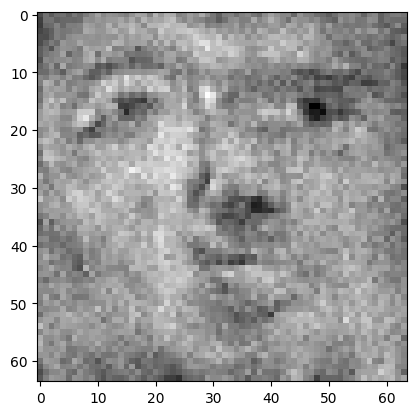

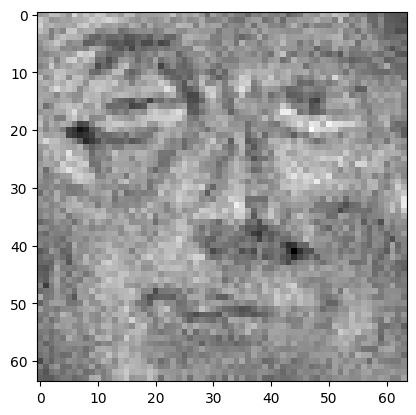

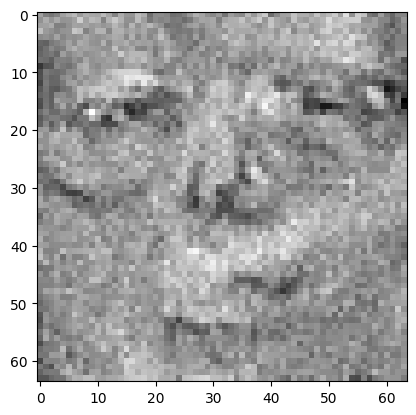

Epoch 62 : 


100%|██████████| 400/400 [00:21<00:00, 18.99it/s]


loss 0.21410840092107006
Epoch 63 : 


100%|██████████| 400/400 [00:20<00:00, 19.68it/s]


loss 0.16560455261170842
Epoch 64 : 


100%|██████████| 400/400 [00:21<00:00, 19.00it/s]


loss 0.2476556318555415
Epoch 65 : 


100%|██████████| 400/400 [00:21<00:00, 18.94it/s]


loss 0.22749137091116572
Epoch 66 : 


100%|██████████| 400/400 [00:20<00:00, 19.28it/s]


loss 0.24862708523985874
Epoch 67 : 


100%|██████████| 400/400 [00:20<00:00, 19.65it/s]


loss 0.15629124344026674
Epoch 68 : 


100%|██████████| 400/400 [00:20<00:00, 19.28it/s]


loss 0.2058040824198061
Epoch 69 : 


100%|██████████| 400/400 [00:20<00:00, 19.29it/s]


loss 0.18491006902783008
Epoch 70 : 


100%|██████████| 400/400 [00:20<00:00, 19.26it/s]


loss 0.25526672645464465
Epoch 71 : 


100%|██████████| 400/400 [00:20<00:00, 19.60it/s]


loss 0.20205215681605962
Epoch 72 : 


100%|██████████| 400/400 [00:20<00:00, 19.95it/s]


loss 0.20662056651407892
Epoch 73 : 


100%|██████████| 400/400 [00:20<00:00, 19.28it/s]


loss 0.25283035205714327
Epoch 74 : 


100%|██████████| 400/400 [00:20<00:00, 19.42it/s]


loss 0.17207160874808894
Epoch 75 : 


100%|██████████| 400/400 [00:20<00:00, 19.37it/s]


loss 0.22985852610155694
Epoch 76 : 


100%|██████████| 400/400 [00:20<00:00, 19.21it/s]


loss 0.19235130790352326
Epoch 77 : 


100%|██████████| 400/400 [00:20<00:00, 19.80it/s]


loss 0.267692244107134
Epoch 78 : 


100%|██████████| 400/400 [00:20<00:00, 19.55it/s]


loss 0.22222093844953883
Epoch 79 : 


100%|██████████| 400/400 [00:20<00:00, 19.27it/s]


loss 0.1935796121149086
Epoch 80 : 


100%|██████████| 400/400 [00:20<00:00, 19.26it/s]


loss 0.17710872064206842
Epoch 81 : 


100%|██████████| 400/400 [00:20<00:00, 19.22it/s]


loss 0.1620133330139394
torch.Size([3, 1, 64, 64])


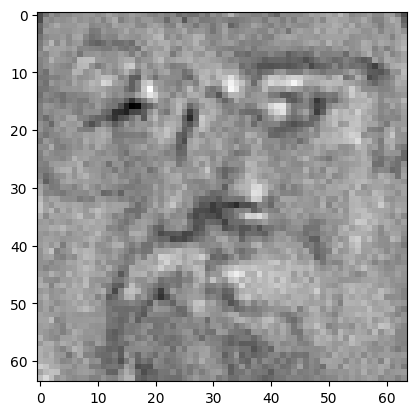

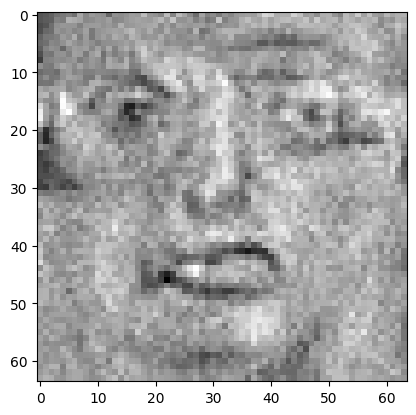

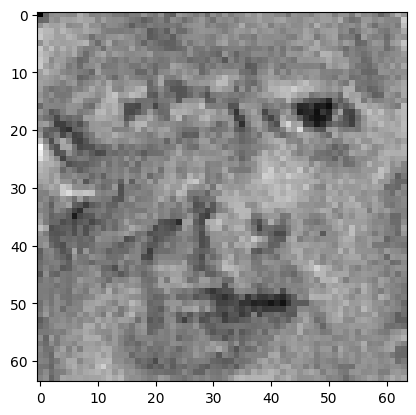

Epoch 82 : 


100%|██████████| 400/400 [00:20<00:00, 19.20it/s]


loss 0.19605272288794384
Epoch 83 : 


100%|██████████| 400/400 [00:21<00:00, 18.62it/s]


loss 0.17049253866467953
Epoch 84 : 


100%|██████████| 400/400 [00:20<00:00, 19.48it/s]


loss 0.2864333721478338
Epoch 85 : 


100%|██████████| 400/400 [00:20<00:00, 19.62it/s]


loss 0.20768113853603773
Epoch 86 : 


100%|██████████| 400/400 [00:20<00:00, 19.18it/s]


loss 0.1994460835707845
Epoch 87 : 


100%|██████████| 400/400 [00:20<00:00, 19.17it/s]


loss 0.19968468661560573
Epoch 88 : 


100%|██████████| 400/400 [00:20<00:00, 19.65it/s]


loss 0.15629152880433078
Epoch 89 : 


100%|██████████| 400/400 [00:21<00:00, 19.02it/s]


loss 0.22966723929050126
Epoch 90 : 


100%|██████████| 400/400 [00:20<00:00, 19.48it/s]


loss 0.2003080686975476
Epoch 91 : 


100%|██████████| 400/400 [00:20<00:00, 19.05it/s]


loss 0.21259408784358977
Epoch 92 : 


100%|██████████| 400/400 [00:20<00:00, 19.21it/s]


loss 0.2260665568461758
Epoch 93 : 


100%|██████████| 400/400 [00:21<00:00, 18.28it/s]


loss 0.18323018612365163
Epoch 94 : 


100%|██████████| 400/400 [00:21<00:00, 18.82it/s]


loss 0.1946661029805818
Epoch 95 : 


100%|██████████| 400/400 [00:22<00:00, 17.81it/s]


loss 0.1862056601139188
Epoch 96 : 


100%|██████████| 400/400 [00:21<00:00, 19.02it/s]


loss 0.18770554593463978
Epoch 97 : 


100%|██████████| 400/400 [00:21<00:00, 18.94it/s]


loss 0.17833139020238178
Epoch 98 : 


100%|██████████| 400/400 [00:20<00:00, 19.09it/s]


loss 0.24911803993903747
Epoch 99 : 


100%|██████████| 400/400 [00:20<00:00, 19.40it/s]


loss 0.20412989268001708
Epoch 100 : 


100%|██████████| 400/400 [00:21<00:00, 18.27it/s]


loss 0.21724049061029496
Epoch 101 : 


100%|██████████| 400/400 [00:21<00:00, 19.01it/s]


loss 0.20826620043275967
torch.Size([3, 1, 64, 64])


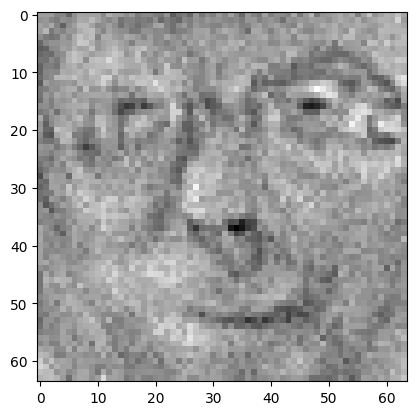

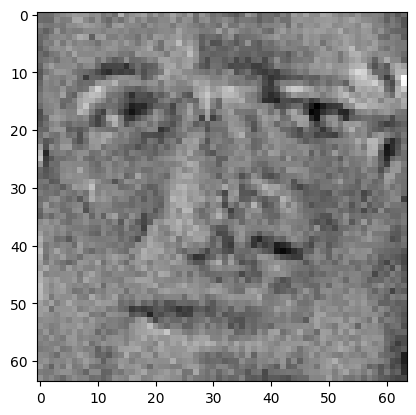

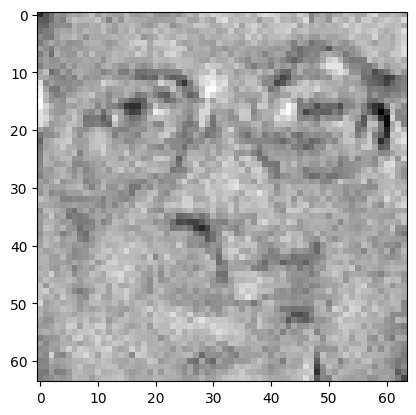

Epoch 102 : 


100%|██████████| 400/400 [00:21<00:00, 18.90it/s]


loss 0.19621476675934998
Epoch 103 : 


100%|██████████| 400/400 [00:21<00:00, 18.56it/s]


loss 0.2776066790137009
Epoch 104 : 


100%|██████████| 400/400 [00:21<00:00, 18.95it/s]


loss 0.1874801053369612
Epoch 105 : 


100%|██████████| 400/400 [00:21<00:00, 18.70it/s]


loss 0.20816740744039944
Epoch 106 : 


100%|██████████| 400/400 [00:21<00:00, 18.49it/s]


loss 0.24805040137162454
Epoch 107 : 


100%|██████████| 400/400 [00:21<00:00, 18.54it/s]


loss 0.2911129108952138
Epoch 108 : 


100%|██████████| 400/400 [00:22<00:00, 18.14it/s]


loss 0.2082161989537623
Epoch 109 : 


100%|██████████| 400/400 [00:20<00:00, 19.11it/s]


loss 0.21196664795067108
Epoch 110 : 


100%|██████████| 400/400 [00:21<00:00, 18.91it/s]


loss 0.15970028269456046
Epoch 111 : 


100%|██████████| 400/400 [00:20<00:00, 19.05it/s]


loss 0.16082112683949454
Epoch 112 : 


100%|██████████| 400/400 [00:20<00:00, 19.38it/s]


loss 0.18638793030755496
Epoch 113 : 


100%|██████████| 400/400 [00:21<00:00, 18.87it/s]


loss 0.14513920904590674
Epoch 114 : 


100%|██████████| 400/400 [00:21<00:00, 18.54it/s]


loss 0.1764359926569587
Epoch 115 : 


100%|██████████| 400/400 [00:21<00:00, 18.63it/s]


loss 0.22100638667669964
Epoch 116 : 


100%|██████████| 400/400 [00:21<00:00, 18.76it/s]


loss 0.2200684560229424
Epoch 117 : 


100%|██████████| 400/400 [00:21<00:00, 18.92it/s]


loss 0.23027447431553913
Epoch 118 : 


100%|██████████| 400/400 [00:21<00:00, 18.63it/s]


loss 0.19851750347653696
Epoch 119 : 


100%|██████████| 400/400 [00:21<00:00, 18.91it/s]


loss 0.2758690733069704
Epoch 120 : 


100%|██████████| 400/400 [00:21<00:00, 18.48it/s]


loss 0.15396296869322276
Epoch 121 : 


100%|██████████| 400/400 [00:21<00:00, 18.78it/s]


loss 0.16524460791988313
torch.Size([3, 1, 64, 64])


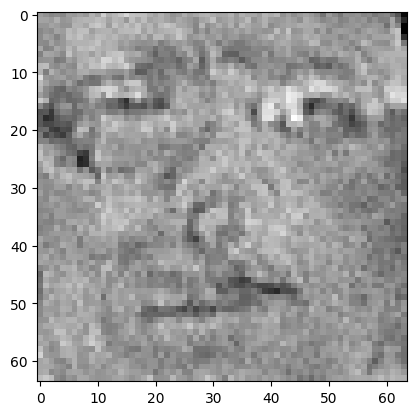

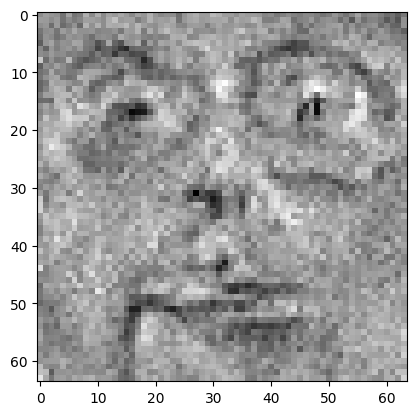

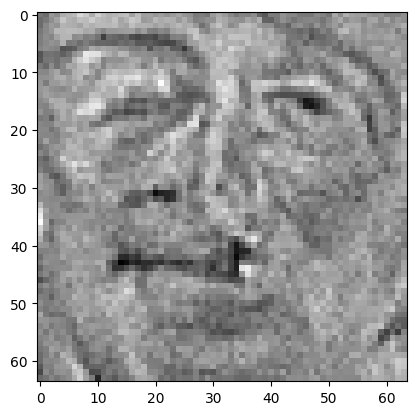

Epoch 122 : 


100%|██████████| 400/400 [00:20<00:00, 19.11it/s]


loss 0.22127405851449775
Epoch 123 : 


100%|██████████| 400/400 [00:21<00:00, 18.93it/s]


loss 0.3199090413642885
Epoch 124 : 


100%|██████████| 400/400 [00:20<00:00, 19.17it/s]


loss 0.18429006874973317
Epoch 125 : 


100%|██████████| 400/400 [00:20<00:00, 19.37it/s]


loss 0.21686692089466256
Epoch 126 : 


100%|██████████| 400/400 [00:21<00:00, 18.55it/s]


loss 0.17616665059372377
Epoch 127 : 


100%|██████████| 400/400 [00:20<00:00, 19.08it/s]


loss 0.25949066972776963
Epoch 128 : 


100%|██████████| 400/400 [00:20<00:00, 19.21it/s]


loss 0.21457232647165897
Epoch 129 : 


100%|██████████| 400/400 [00:20<00:00, 19.52it/s]


loss 0.2252071677943759
Epoch 130 : 


100%|██████████| 400/400 [00:20<00:00, 19.39it/s]


loss 0.16995683523372673
Epoch 131 : 


100%|██████████| 400/400 [00:20<00:00, 19.49it/s]


loss 0.14466264503567555
Epoch 132 : 


100%|██████████| 400/400 [00:21<00:00, 19.02it/s]


loss 0.34219485680915185
Epoch 133 : 


100%|██████████| 400/400 [00:20<00:00, 19.37it/s]


loss 0.22797163360507297
Epoch 134 : 


100%|██████████| 400/400 [00:21<00:00, 18.33it/s]


loss 0.2364905845360284
Epoch 135 : 


100%|██████████| 400/400 [00:21<00:00, 18.77it/s]


loss 0.2788273910027789
Epoch 136 : 


100%|██████████| 400/400 [00:21<00:00, 18.76it/s]


loss 0.16651058768547145
Epoch 137 : 


100%|██████████| 400/400 [00:21<00:00, 18.69it/s]


loss 0.22243110689466417
Epoch 138 : 


100%|██████████| 400/400 [00:21<00:00, 18.29it/s]


loss 0.16038219747554758
Epoch 139 : 


100%|██████████| 400/400 [00:21<00:00, 18.93it/s]


loss 0.17463095849915972
Epoch 140 : 


100%|██████████| 400/400 [00:20<00:00, 19.31it/s]


loss 0.1954004569956473
Epoch 141 : 


100%|██████████| 400/400 [00:21<00:00, 18.94it/s]


loss 0.19407155978987164
torch.Size([3, 1, 64, 64])


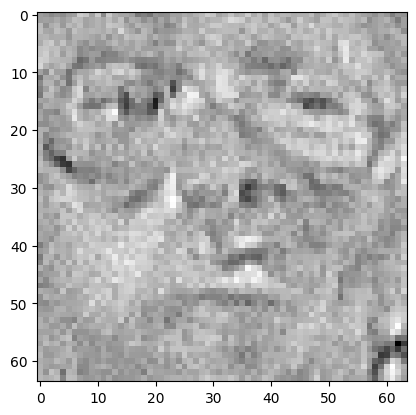

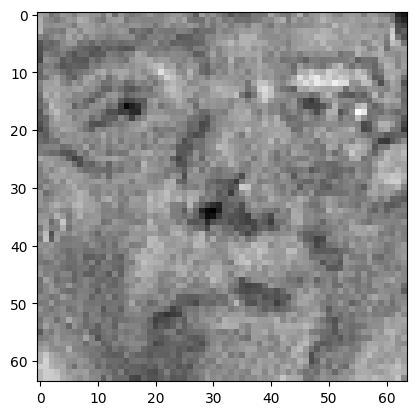

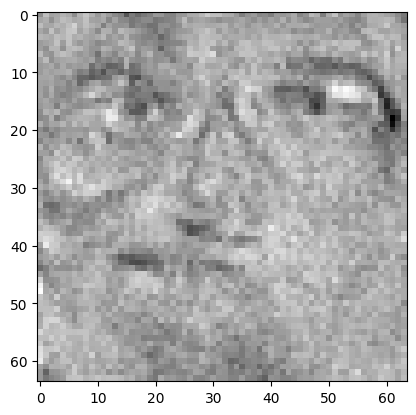

Epoch 142 : 


100%|██████████| 400/400 [00:21<00:00, 19.00it/s]


loss 0.24477272654092036
Epoch 143 : 


100%|██████████| 400/400 [00:21<00:00, 18.88it/s]


loss 0.18769327172946107
Epoch 144 : 


100%|██████████| 400/400 [00:22<00:00, 18.09it/s]


loss 0.15246754350852068
Epoch 145 : 


100%|██████████| 400/400 [00:21<00:00, 18.58it/s]


loss 0.15076382554430395
Epoch 146 : 


100%|██████████| 400/400 [00:21<00:00, 18.80it/s]


loss 0.25932424492218864
Epoch 147 : 


100%|██████████| 400/400 [00:22<00:00, 17.91it/s]


loss 0.3019718972206767
Epoch 148 : 


100%|██████████| 400/400 [00:21<00:00, 18.73it/s]


loss 0.2147004642334395
Epoch 149 : 


100%|██████████| 400/400 [00:21<00:00, 18.38it/s]


loss 0.15460607014484706
Epoch 150 : 


100%|██████████| 400/400 [00:19<00:00, 20.49it/s]


loss 0.15921570150246164
Epoch 151 : 


100%|██████████| 400/400 [00:18<00:00, 21.19it/s]


loss 0.16828601058812656
Epoch 152 : 


100%|██████████| 400/400 [00:19<00:00, 20.85it/s]


loss 0.23268050422699776
Epoch 153 : 


100%|██████████| 400/400 [00:19<00:00, 20.33it/s]


loss 0.15621230069515066
Epoch 154 : 


100%|██████████| 400/400 [00:19<00:00, 20.39it/s]


loss 0.28120291321707847
Epoch 155 : 


100%|██████████| 400/400 [00:19<00:00, 20.99it/s]


loss 0.2342915807744271
Epoch 156 : 


100%|██████████| 400/400 [00:18<00:00, 21.16it/s]


loss 0.19993481361991655
Epoch 157 : 


100%|██████████| 400/400 [00:19<00:00, 20.55it/s]


loss 0.17094989317471393
Epoch 158 : 


100%|██████████| 400/400 [00:19<00:00, 20.73it/s]


loss 0.18502233393839035
Epoch 159 : 


100%|██████████| 400/400 [00:18<00:00, 21.54it/s]


loss 0.21352933075954827
Epoch 160 : 


100%|██████████| 400/400 [00:18<00:00, 21.15it/s]


loss 0.20849919802560396
Epoch 161 : 


100%|██████████| 400/400 [00:19<00:00, 20.66it/s]


loss 0.22026706853746064
torch.Size([3, 1, 64, 64])


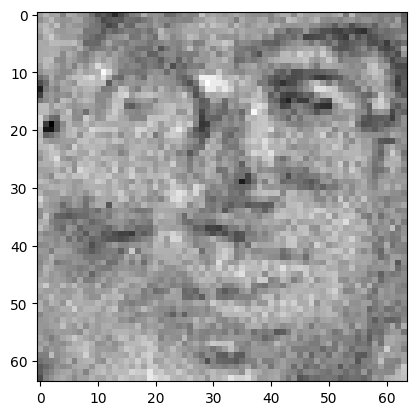

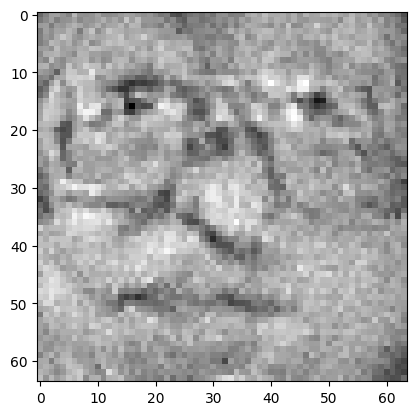

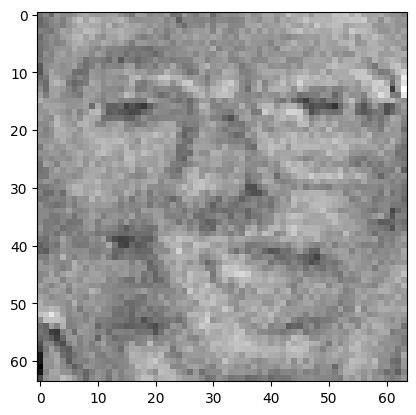

Epoch 162 : 


100%|██████████| 400/400 [00:19<00:00, 20.65it/s]


loss 0.26081610537976696
Epoch 163 : 


100%|██████████| 400/400 [00:19<00:00, 20.67it/s]


loss 0.1935259711248149
Epoch 164 : 


100%|██████████| 400/400 [00:19<00:00, 20.49it/s]


loss 0.14639385220622944
Epoch 165 : 


100%|██████████| 400/400 [00:18<00:00, 21.81it/s]


loss 0.22824524744842473
Epoch 166 : 


100%|██████████| 400/400 [00:19<00:00, 20.25it/s]


loss 0.14907926948422454
Epoch 167 : 


100%|██████████| 400/400 [00:19<00:00, 20.57it/s]


loss 0.16794771579511167
Epoch 168 : 


100%|██████████| 400/400 [00:18<00:00, 21.14it/s]


loss 0.2756516456167999
Epoch 169 : 


100%|██████████| 400/400 [00:19<00:00, 20.14it/s]


loss 0.27058929317653274
Epoch 170 : 


100%|██████████| 400/400 [00:20<00:00, 19.90it/s]


loss 0.15254155522731394
Epoch 171 : 


100%|██████████| 400/400 [00:18<00:00, 21.22it/s]


loss 0.16811802639732693
Epoch 172 : 


100%|██████████| 400/400 [00:19<00:00, 20.42it/s]


loss 0.1403504225820633
Epoch 173 : 


100%|██████████| 400/400 [00:19<00:00, 20.28it/s]


loss 0.18208543183400355
Epoch 174 : 


100%|██████████| 400/400 [00:18<00:00, 21.10it/s]


loss 0.2152577601331306
Epoch 175 : 


100%|██████████| 400/400 [00:19<00:00, 20.71it/s]


loss 0.18570848515219945
Epoch 176 : 


100%|██████████| 400/400 [00:20<00:00, 19.90it/s]


loss 0.2739603676664
Epoch 177 : 


100%|██████████| 400/400 [00:18<00:00, 21.15it/s]


loss 0.13643096718839703
Epoch 178 : 


100%|██████████| 400/400 [00:19<00:00, 20.66it/s]


loss 0.16518494505345774
Epoch 179 : 


100%|██████████| 400/400 [00:19<00:00, 20.99it/s]


loss 0.16815250522839112
Epoch 180 : 


100%|██████████| 400/400 [00:19<00:00, 20.11it/s]


loss 0.2764715439117232
Epoch 181 : 


100%|██████████| 400/400 [00:19<00:00, 20.83it/s]


loss 0.16425746631445612
torch.Size([3, 1, 64, 64])


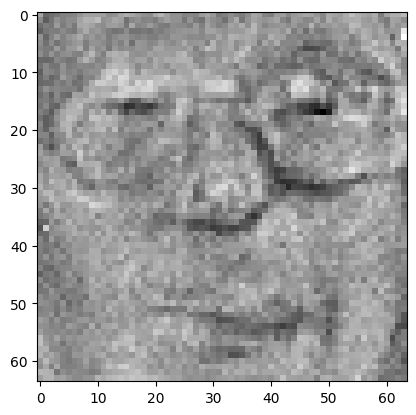

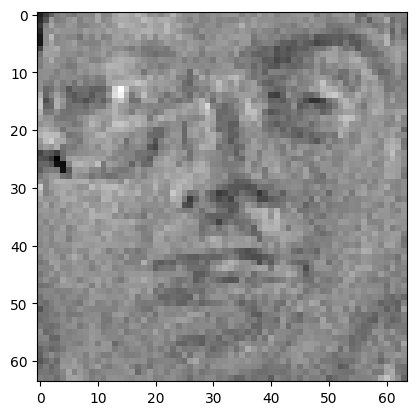

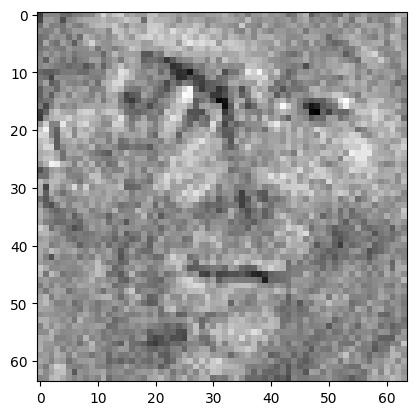

Epoch 182 : 


100%|██████████| 400/400 [00:19<00:00, 20.06it/s]


loss 0.11452377748572903
Epoch 183 : 


100%|██████████| 400/400 [00:19<00:00, 20.71it/s]


loss 0.1453903484058637
Epoch 184 : 


100%|██████████| 400/400 [00:19<00:00, 20.72it/s]


loss 0.20970585760790533
Epoch 185 : 


100%|██████████| 400/400 [00:18<00:00, 21.08it/s]


loss 0.13665159272595767
Epoch 186 : 


100%|██████████| 400/400 [00:19<00:00, 20.51it/s]


loss 0.17281074735919744
Epoch 187 : 


100%|██████████| 400/400 [00:19<00:00, 20.70it/s]


loss 0.16104007490530742
Epoch 188 : 


100%|██████████| 400/400 [00:19<00:00, 20.68it/s]


loss 0.2852355681584754
Epoch 189 : 


100%|██████████| 400/400 [00:19<00:00, 20.93it/s]


loss 0.18746885843202893
Epoch 190 : 


100%|██████████| 400/400 [00:19<00:00, 20.90it/s]


loss 0.15543017666809453
Epoch 191 : 


100%|██████████| 400/400 [00:19<00:00, 20.22it/s]


loss 0.2628615535623698
Epoch 192 : 


100%|██████████| 400/400 [00:20<00:00, 19.87it/s]


loss 0.23306818081277644
Epoch 193 : 


100%|██████████| 400/400 [00:20<00:00, 19.88it/s]


loss 0.19413134005691152
Epoch 194 : 


100%|██████████| 400/400 [00:20<00:00, 19.63it/s]


loss 0.15583306265115252
Epoch 195 : 


100%|██████████| 400/400 [00:21<00:00, 18.51it/s]


loss 0.22149408435997073
Epoch 196 : 


100%|██████████| 400/400 [00:20<00:00, 19.09it/s]


loss 0.21991501549032
Epoch 197 : 


100%|██████████| 400/400 [00:21<00:00, 18.99it/s]


loss 0.2324822436297855
Epoch 198 : 


100%|██████████| 400/400 [00:21<00:00, 19.03it/s]


loss 0.17479499135821475
Epoch 199 : 


100%|██████████| 400/400 [00:20<00:00, 19.32it/s]


loss 0.2355713290905881
Epoch 200 : 


100%|██████████| 400/400 [00:18<00:00, 21.17it/s]


loss 0.29213675632931396
Epoch 201 : 


100%|██████████| 400/400 [00:21<00:00, 18.89it/s]


loss 0.19067061682103809
torch.Size([3, 1, 64, 64])


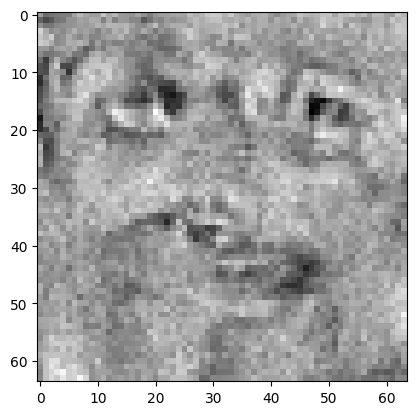

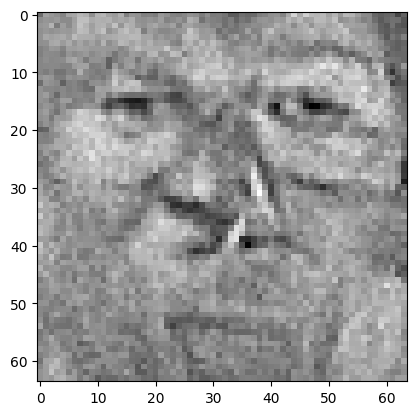

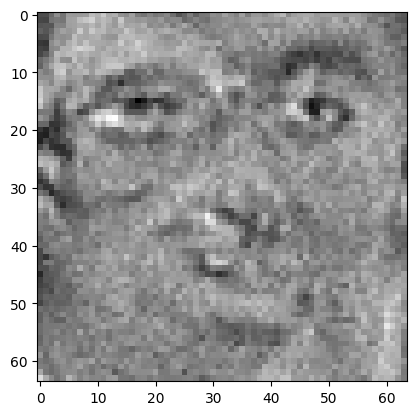

Epoch 202 : 


100%|██████████| 400/400 [00:21<00:00, 18.34it/s]


loss 0.3383226418798673
Epoch 203 : 


100%|██████████| 400/400 [00:21<00:00, 18.47it/s]


loss 0.2999653654641893
Epoch 204 : 


100%|██████████| 400/400 [00:21<00:00, 18.65it/s]


loss 0.24888591365317944
Epoch 205 : 


100%|██████████| 400/400 [00:21<00:00, 18.59it/s]


loss 0.2139584538429951
Epoch 206 : 


100%|██████████| 400/400 [00:20<00:00, 19.24it/s]


loss 0.16990394274950904
Epoch 207 : 


100%|██████████| 400/400 [00:21<00:00, 18.80it/s]


loss 0.17671254391111682
Epoch 208 : 


100%|██████████| 400/400 [00:21<00:00, 18.68it/s]


loss 0.1837402704778704
Epoch 209 : 


100%|██████████| 400/400 [00:21<00:00, 18.78it/s]


loss 0.21319385300620858
Epoch 210 : 


100%|██████████| 400/400 [00:20<00:00, 19.14it/s]


loss 0.23401563104674739
Epoch 211 : 


100%|██████████| 400/400 [00:21<00:00, 18.68it/s]


loss 0.24890718252764046
Epoch 212 : 


100%|██████████| 400/400 [00:22<00:00, 18.18it/s]


loss 0.20873563988397292
Epoch 213 : 


100%|██████████| 400/400 [00:21<00:00, 18.79it/s]


loss 0.14106464368903016
Epoch 214 : 


100%|██████████| 400/400 [00:21<00:00, 18.87it/s]


loss 0.2351463447498405
Epoch 215 : 


100%|██████████| 400/400 [00:21<00:00, 18.21it/s]


loss 0.26865046518877883
Epoch 216 : 


100%|██████████| 400/400 [00:21<00:00, 18.71it/s]


loss 0.2238492542359226
Epoch 217 : 


100%|██████████| 400/400 [00:20<00:00, 19.09it/s]


loss 0.2570951681845883
Epoch 218 : 


100%|██████████| 400/400 [00:20<00:00, 19.10it/s]


loss 0.2724956574169223
Epoch 219 : 


100%|██████████| 400/400 [00:20<00:00, 19.40it/s]


loss 0.26633121362742823
Epoch 220 : 


100%|██████████| 400/400 [00:21<00:00, 18.35it/s]


loss 0.18207530108577735
Epoch 221 : 


100%|██████████| 400/400 [00:21<00:00, 18.89it/s]


loss 0.2433755599383094
torch.Size([3, 1, 64, 64])


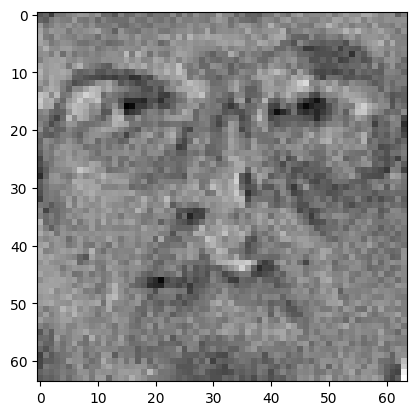

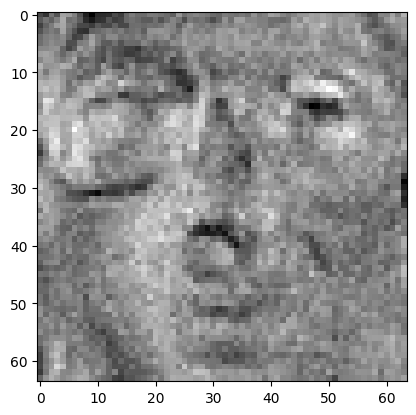

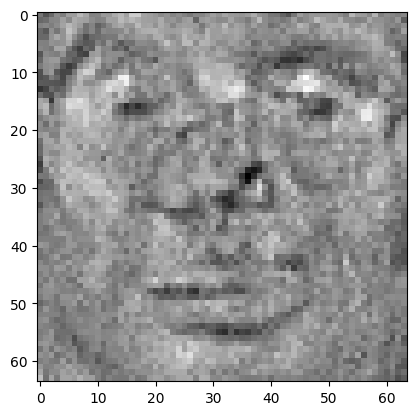

Epoch 222 : 


100%|██████████| 400/400 [00:21<00:00, 18.70it/s]


loss 0.24031333314820547
Epoch 223 : 


100%|██████████| 400/400 [00:21<00:00, 18.76it/s]


loss 0.289843241890032
Epoch 224 : 


100%|██████████| 400/400 [00:21<00:00, 18.49it/s]


loss 0.3108178429119702
Epoch 225 : 


100%|██████████| 400/400 [00:21<00:00, 18.84it/s]


loss 0.22764113049508553
Epoch 226 : 


100%|██████████| 400/400 [00:21<00:00, 18.68it/s]


loss 0.150010126115477
Epoch 227 : 


100%|██████████| 400/400 [00:21<00:00, 18.56it/s]


loss 0.16129975914468642
Epoch 228 : 


100%|██████████| 400/400 [00:21<00:00, 18.56it/s]


loss 0.1984485032777849
Epoch 229 : 


100%|██████████| 400/400 [00:20<00:00, 19.34it/s]


loss 0.26012629959962563
Epoch 230 : 


100%|██████████| 400/400 [00:21<00:00, 18.49it/s]


loss 0.2710414060427075
Epoch 231 : 


100%|██████████| 400/400 [00:20<00:00, 19.06it/s]


loss 0.2106935281793026
Epoch 232 : 


100%|██████████| 400/400 [00:21<00:00, 18.87it/s]


loss 0.1626332671984683
Epoch 233 : 


100%|██████████| 400/400 [00:21<00:00, 18.45it/s]


loss 0.2205433916990297
Epoch 234 : 


100%|██████████| 400/400 [00:21<00:00, 18.95it/s]


loss 0.19187424531271138
Epoch 235 : 


100%|██████████| 400/400 [00:21<00:00, 18.54it/s]


loss 0.2052688350375935
Epoch 236 : 


100%|██████████| 400/400 [00:20<00:00, 19.11it/s]


loss 0.17136998802305795
Epoch 237 : 


100%|██████████| 400/400 [00:21<00:00, 18.73it/s]


loss 0.15943762965171038
Epoch 238 : 


100%|██████████| 400/400 [00:21<00:00, 18.68it/s]


loss 0.2010587103344143
Epoch 239 : 


100%|██████████| 400/400 [00:21<00:00, 18.86it/s]


loss 0.21852663610340622
Epoch 240 : 


100%|██████████| 400/400 [00:21<00:00, 19.02it/s]


loss 0.2035032011429234
Epoch 241 : 


100%|██████████| 400/400 [00:21<00:00, 18.82it/s]


loss 0.20376798515832806
torch.Size([3, 1, 64, 64])


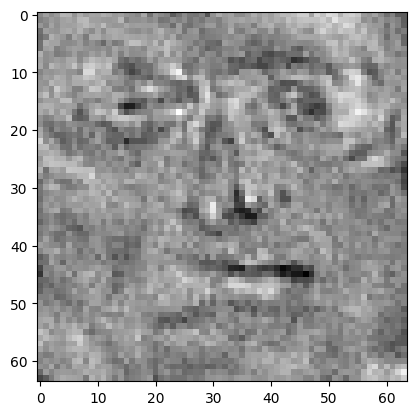

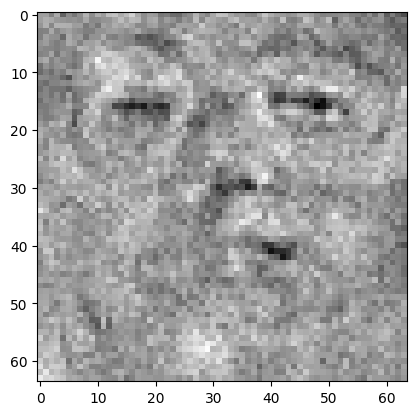

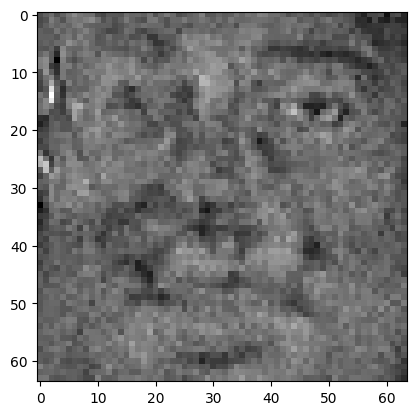

Epoch 242 : 


100%|██████████| 400/400 [00:21<00:00, 18.27it/s]


loss 0.26022651117926937
Epoch 243 : 


100%|██████████| 400/400 [00:21<00:00, 18.54it/s]


loss 0.17792090779389705
Epoch 244 : 


100%|██████████| 400/400 [00:21<00:00, 18.70it/s]


loss 0.26532287312881625
Epoch 245 : 


100%|██████████| 400/400 [00:21<00:00, 18.77it/s]


loss 0.173081521600338
Epoch 246 : 


100%|██████████| 400/400 [00:21<00:00, 18.72it/s]


loss 0.17279278799774922
Epoch 247 : 


100%|██████████| 400/400 [00:21<00:00, 18.89it/s]


loss 0.2403181911849624
Epoch 248 : 


100%|██████████| 400/400 [00:20<00:00, 19.35it/s]


loss 0.19645324081134474
Epoch 249 : 


100%|██████████| 400/400 [00:21<00:00, 18.51it/s]


loss 0.2683120837551174
Epoch 250 : 


100%|██████████| 400/400 [00:20<00:00, 19.07it/s]


loss 0.2766309820888084
Epoch 251 : 


100%|██████████| 400/400 [00:20<00:00, 19.19it/s]


loss 0.21745087619873596
Epoch 252 : 


100%|██████████| 400/400 [00:21<00:00, 18.79it/s]


loss 0.23507595111082233
Epoch 253 : 


100%|██████████| 400/400 [00:20<00:00, 19.26it/s]


loss 0.18312344740948386
Epoch 254 : 


100%|██████████| 400/400 [00:21<00:00, 18.75it/s]


loss 0.24644058358223436
Epoch 255 : 


100%|██████████| 400/400 [00:20<00:00, 19.15it/s]


loss 0.20560922369536674
Epoch 256 : 


100%|██████████| 400/400 [00:21<00:00, 18.50it/s]


loss 0.21062707553336882
Epoch 257 : 


100%|██████████| 400/400 [00:21<00:00, 18.94it/s]


loss 0.22278059703984235
Epoch 258 : 


100%|██████████| 400/400 [00:21<00:00, 18.94it/s]


loss 0.19392704118787013
Epoch 259 : 


100%|██████████| 400/400 [00:21<00:00, 19.02it/s]


loss 0.17585230957425135
Epoch 260 : 


100%|██████████| 400/400 [00:21<00:00, 18.27it/s]


loss 0.19385398503745338
Epoch 261 : 


100%|██████████| 400/400 [00:21<00:00, 18.70it/s]


loss 0.1473339976478566
torch.Size([3, 1, 64, 64])


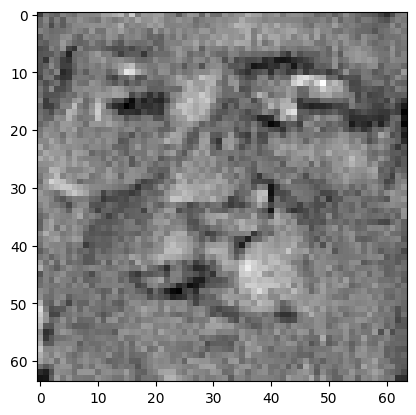

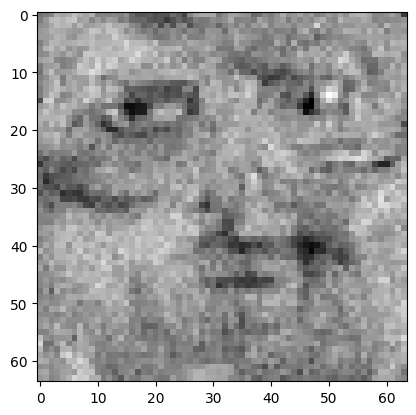

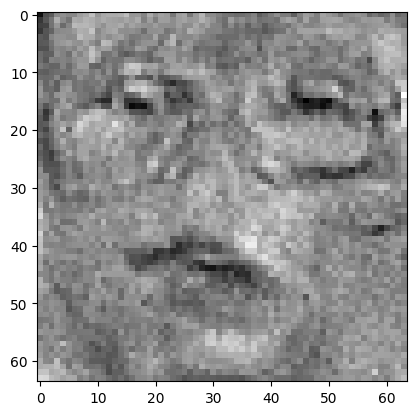

Epoch 262 : 


100%|██████████| 400/400 [00:21<00:00, 18.50it/s]


loss 0.1646907613289089
Epoch 263 : 


100%|██████████| 400/400 [00:21<00:00, 18.74it/s]


loss 0.21840490750480868
Epoch 264 : 


100%|██████████| 400/400 [00:20<00:00, 19.41it/s]


loss 0.25943410420450597
Epoch 265 : 


100%|██████████| 400/400 [00:21<00:00, 18.25it/s]


loss 0.13039610493721024
Epoch 266 : 


100%|██████████| 400/400 [00:21<00:00, 18.90it/s]


loss 0.17209432210120976
Epoch 267 : 


100%|██████████| 400/400 [00:20<00:00, 19.13it/s]


loss 0.20569735619556812
Epoch 268 : 


100%|██████████| 400/400 [00:21<00:00, 18.98it/s]


loss 0.18550924191290902
Epoch 269 : 


100%|██████████| 400/400 [00:21<00:00, 18.93it/s]


loss 0.13859678097836406
Epoch 270 : 


100%|██████████| 400/400 [00:21<00:00, 18.40it/s]


loss 0.26153163517098554
Epoch 271 : 


100%|██████████| 400/400 [00:21<00:00, 18.43it/s]


loss 0.15109608216292658
Epoch 272 : 


100%|██████████| 400/400 [00:21<00:00, 18.99it/s]


loss 0.19734180137113003
Epoch 273 : 


100%|██████████| 400/400 [00:21<00:00, 18.76it/s]


loss 0.24515021299791345
Epoch 274 : 


100%|██████████| 400/400 [00:21<00:00, 18.20it/s]


loss 0.27659073142915913
Epoch 275 : 


100%|██████████| 400/400 [00:20<00:00, 19.13it/s]


loss 0.200167653292711
Epoch 276 : 


100%|██████████| 400/400 [00:20<00:00, 19.08it/s]


loss 0.2641059938175491
Epoch 277 : 


100%|██████████| 400/400 [00:21<00:00, 18.66it/s]


loss 0.18546708744830465
Epoch 278 : 


100%|██████████| 400/400 [00:20<00:00, 19.46it/s]


loss 0.220719894430175
Epoch 279 : 


100%|██████████| 400/400 [00:21<00:00, 18.51it/s]


loss 0.14945142089723962
Epoch 280 : 


100%|██████████| 400/400 [00:20<00:00, 19.41it/s]


loss 0.15924707346550446
Epoch 281 : 


100%|██████████| 400/400 [00:20<00:00, 19.55it/s]


loss 0.25869606124782324
torch.Size([3, 1, 64, 64])


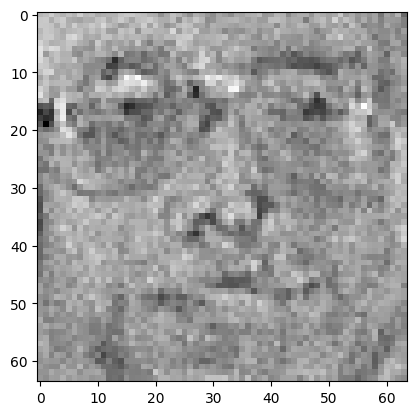

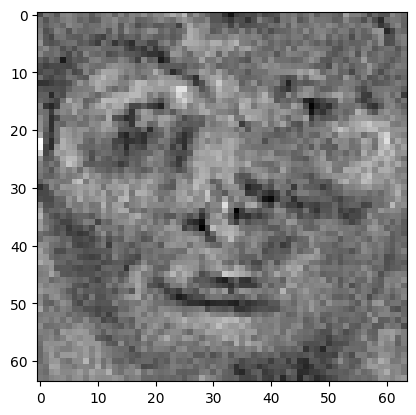

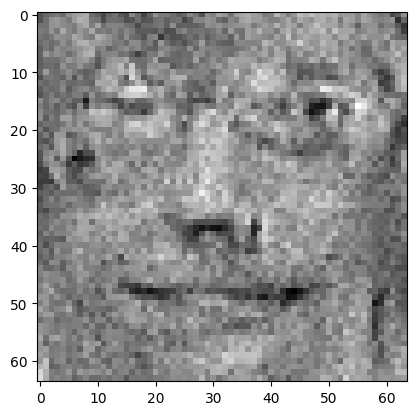

Epoch 282 : 


100%|██████████| 400/400 [00:21<00:00, 18.60it/s]


loss 0.276259842072502
Epoch 283 : 


100%|██████████| 400/400 [00:20<00:00, 19.20it/s]


loss 0.20683972511273316
Epoch 284 : 


100%|██████████| 400/400 [00:21<00:00, 18.67it/s]


loss 0.2597195509741008
Epoch 285 : 


100%|██████████| 400/400 [00:21<00:00, 18.96it/s]


loss 0.17530433867396156
Epoch 286 : 


100%|██████████| 400/400 [00:21<00:00, 18.73it/s]


loss 0.19157114142085085
Epoch 287 : 


100%|██████████| 400/400 [00:21<00:00, 18.61it/s]


loss 0.19915495979244008
Epoch 288 : 


100%|██████████| 400/400 [00:20<00:00, 19.07it/s]


loss 0.21393783548402676
Epoch 289 : 


100%|██████████| 400/400 [00:21<00:00, 18.64it/s]


loss 0.24750658073574594
Epoch 290 : 


100%|██████████| 400/400 [00:21<00:00, 18.86it/s]


loss 0.2844916599254486
Epoch 291 : 


100%|██████████| 400/400 [00:21<00:00, 18.62it/s]


loss 0.16835841168561644
Epoch 292 : 


100%|██████████| 400/400 [00:21<00:00, 18.90it/s]


loss 0.30420823190163543
Epoch 293 : 


100%|██████████| 400/400 [00:21<00:00, 18.80it/s]


loss 0.1793360227981006
Epoch 294 : 


100%|██████████| 400/400 [00:21<00:00, 18.51it/s]


loss 0.23979524504773167
Epoch 295 : 


100%|██████████| 400/400 [00:21<00:00, 18.28it/s]


loss 0.25534781844656645
Epoch 296 : 


100%|██████████| 400/400 [00:21<00:00, 18.98it/s]


loss 0.16900140369132932
Epoch 297 : 


100%|██████████| 400/400 [00:21<00:00, 18.24it/s]


loss 0.27954912185798536
Epoch 298 : 


100%|██████████| 400/400 [00:21<00:00, 18.78it/s]


loss 0.20058901269533996
Epoch 299 : 


100%|██████████| 400/400 [00:20<00:00, 19.30it/s]


loss 0.27629522112041155
Epoch 300 : 


100%|██████████| 400/400 [00:21<00:00, 18.96it/s]


loss 0.1778838959529012
Epoch 301 : 


100%|██████████| 400/400 [00:21<00:00, 18.58it/s]


loss 0.26270376928442724
torch.Size([3, 1, 64, 64])


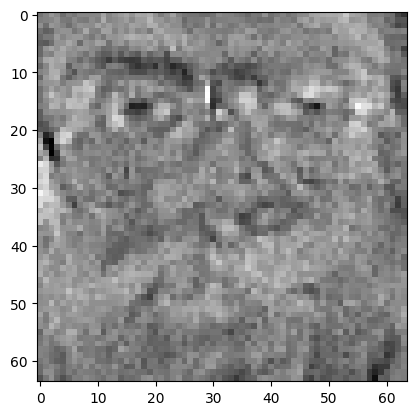

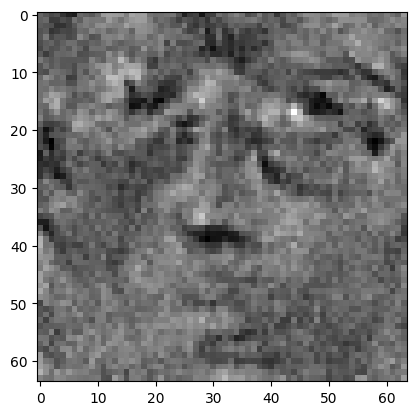

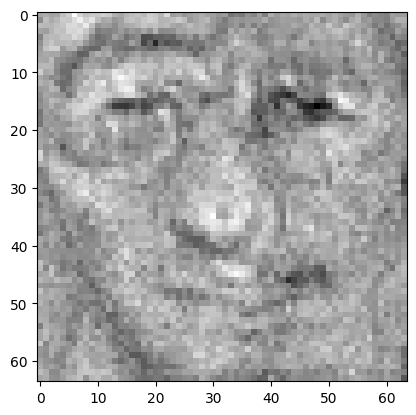

Epoch 302 : 


100%|██████████| 400/400 [00:21<00:00, 18.65it/s]


loss 0.18727578580507764
Epoch 303 : 


100%|██████████| 400/400 [00:21<00:00, 18.80it/s]


loss 0.27613443018611494
Epoch 304 : 


100%|██████████| 400/400 [00:21<00:00, 18.84it/s]


loss 0.17845226649598825
Epoch 305 : 


100%|██████████| 400/400 [00:20<00:00, 19.33it/s]


loss 0.20622601019059925
Epoch 306 : 


100%|██████████| 400/400 [00:21<00:00, 18.67it/s]


loss 0.22817545732523978
Epoch 307 : 


100%|██████████| 400/400 [00:21<00:00, 18.68it/s]


loss 0.19509589441811068
Epoch 308 : 


100%|██████████| 400/400 [00:21<00:00, 18.87it/s]


loss 0.1811754239599046
Epoch 309 : 


100%|██████████| 400/400 [00:21<00:00, 18.89it/s]


loss 0.17278762225918348
Epoch 310 : 


100%|██████████| 400/400 [00:21<00:00, 18.65it/s]


loss 0.20861082724455987
Epoch 311 : 


100%|██████████| 400/400 [00:21<00:00, 18.47it/s]


loss 0.27511956040469887
Epoch 312 : 


100%|██████████| 400/400 [00:21<00:00, 18.84it/s]


loss 0.2125730707489341
Epoch 313 : 


100%|██████████| 400/400 [00:21<00:00, 18.87it/s]


loss 0.20325838909242946
Epoch 314 : 


100%|██████████| 400/400 [00:20<00:00, 19.12it/s]


loss 0.22566330651317018
Epoch 315 : 


100%|██████████| 400/400 [00:21<00:00, 18.80it/s]


loss 0.1608529328924791
Epoch 316 : 


100%|██████████| 400/400 [00:20<00:00, 19.12it/s]


loss 0.21967185218208726
Epoch 317 : 


100%|██████████| 400/400 [00:21<00:00, 18.73it/s]


loss 0.1775294111492515
Epoch 318 : 


100%|██████████| 400/400 [00:21<00:00, 18.40it/s]


loss 0.18083075673355845
Epoch 319 : 


100%|██████████| 400/400 [00:19<00:00, 20.20it/s]


loss 0.23311725881534262
Epoch 320 : 


100%|██████████| 400/400 [00:19<00:00, 20.19it/s]


loss 0.1990393802303171
Epoch 321 : 


100%|██████████| 400/400 [00:20<00:00, 19.88it/s]


loss 0.24042441414299393
torch.Size([3, 1, 64, 64])


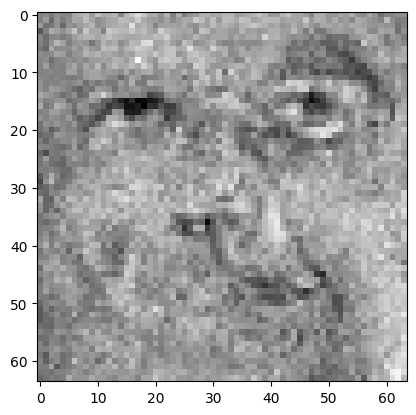

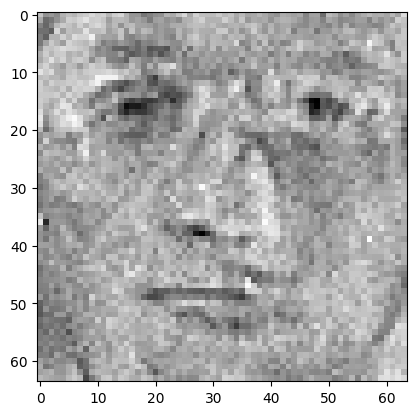

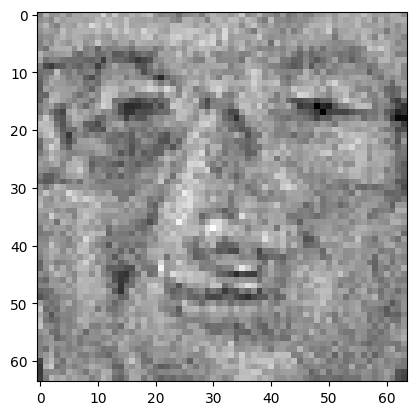

Epoch 322 : 


100%|██████████| 400/400 [00:19<00:00, 20.02it/s]


loss 0.18979297888319757
Epoch 323 : 


100%|██████████| 400/400 [00:19<00:00, 20.32it/s]


loss 0.20385430647496583
Epoch 324 : 


100%|██████████| 400/400 [00:19<00:00, 20.27it/s]


loss 0.13636700551777667
Epoch 325 : 


100%|██████████| 400/400 [00:19<00:00, 20.39it/s]


loss 0.28928470494692715
Epoch 326 : 


100%|██████████| 400/400 [00:20<00:00, 19.50it/s]


loss 0.21588803456227626
Epoch 327 : 


100%|██████████| 400/400 [00:19<00:00, 20.22it/s]


loss 0.22309662187713833
Epoch 328 : 


100%|██████████| 400/400 [00:19<00:00, 20.56it/s]


loss 0.20418487750183809
Epoch 329 : 


100%|██████████| 400/400 [00:19<00:00, 20.03it/s]


loss 0.15917946075739467
Epoch 330 : 


100%|██████████| 400/400 [00:19<00:00, 20.44it/s]


loss 0.25776494344049117
Epoch 331 : 


100%|██████████| 400/400 [00:19<00:00, 20.03it/s]


loss 0.2646948228671722
Epoch 332 : 


100%|██████████| 400/400 [00:20<00:00, 19.80it/s]


loss 0.3017944130195016
Epoch 333 : 


100%|██████████| 400/400 [00:19<00:00, 20.34it/s]


loss 0.17536037308063002
Epoch 334 : 


100%|██████████| 400/400 [00:19<00:00, 20.34it/s]


loss 0.19884291118466138
Epoch 335 : 


100%|██████████| 400/400 [00:19<00:00, 20.48it/s]


loss 0.1776896812237409
Epoch 336 : 


100%|██████████| 400/400 [00:19<00:00, 20.85it/s]


loss 0.2740777805700308
Epoch 337 : 


100%|██████████| 400/400 [00:20<00:00, 19.64it/s]


loss 0.22611442512249524
Epoch 338 : 


100%|██████████| 400/400 [00:19<00:00, 20.18it/s]


loss 0.2564435753009655
Epoch 339 : 


100%|██████████| 400/400 [00:19<00:00, 20.64it/s]


loss 0.19367413248071064
Epoch 340 : 


100%|██████████| 400/400 [00:19<00:00, 20.04it/s]


loss 0.2205380875006701
Epoch 341 : 


100%|██████████| 400/400 [00:20<00:00, 19.76it/s]


loss 0.1717952029036119
torch.Size([3, 1, 64, 64])


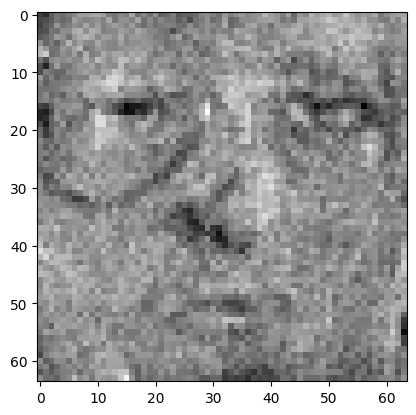

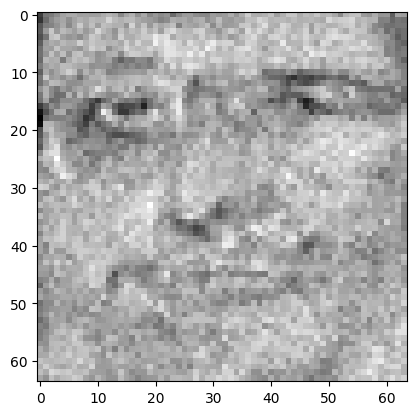

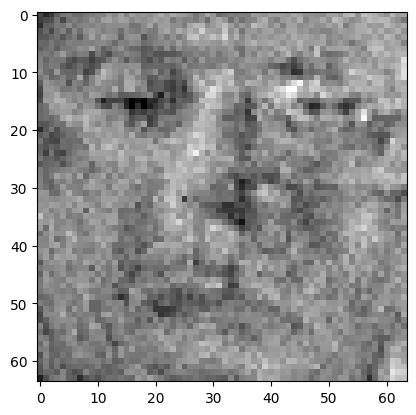

Epoch 342 : 


100%|██████████| 400/400 [00:20<00:00, 19.59it/s]


loss 0.1923529926456139
Epoch 343 : 


100%|██████████| 400/400 [00:20<00:00, 19.93it/s]


loss 0.2783535008315359
Epoch 344 : 


100%|██████████| 400/400 [00:19<00:00, 21.01it/s]


loss 0.20017885297050808
Epoch 345 : 


100%|██████████| 400/400 [00:19<00:00, 20.93it/s]


loss 0.19025357614981522
Epoch 346 : 


100%|██████████| 400/400 [00:19<00:00, 20.29it/s]


loss 0.2381762807423891
Epoch 347 : 


100%|██████████| 400/400 [00:19<00:00, 20.12it/s]


loss 0.19850368506795268
Epoch 348 : 


100%|██████████| 400/400 [00:19<00:00, 20.32it/s]


loss 0.20698863735980472
Epoch 349 : 


100%|██████████| 400/400 [00:19<00:00, 20.08it/s]


loss 0.2828413652972803
Epoch 350 : 


100%|██████████| 400/400 [00:20<00:00, 19.94it/s]


loss 0.1606083993420029
Epoch 351 : 


100%|██████████| 400/400 [00:19<00:00, 20.42it/s]


loss 0.21254727570413867
Epoch 352 : 


100%|██████████| 400/400 [00:19<00:00, 20.61it/s]


loss 0.25263776732837046
Epoch 353 : 


100%|██████████| 400/400 [00:19<00:00, 20.42it/s]


loss 0.25159769918999897
Epoch 354 : 


100%|██████████| 400/400 [00:19<00:00, 20.43it/s]


loss 0.2263647223218639
Epoch 355 : 


100%|██████████| 400/400 [00:19<00:00, 20.47it/s]


loss 0.22248947554654602
Epoch 356 : 


100%|██████████| 400/400 [00:20<00:00, 19.64it/s]


loss 0.28510065297856274
Epoch 357 : 


100%|██████████| 400/400 [00:19<00:00, 20.26it/s]


loss 0.16716794299996282
Epoch 358 : 


100%|██████████| 400/400 [00:19<00:00, 20.01it/s]


loss 0.20946341574914498
Epoch 359 : 


100%|██████████| 400/400 [00:20<00:00, 19.61it/s]


loss 0.2814053647806471
Epoch 360 : 


100%|██████████| 400/400 [00:19<00:00, 20.98it/s]


loss 0.2061035710434106
Epoch 361 : 


100%|██████████| 400/400 [00:19<00:00, 20.33it/s]


loss 0.2733288890885911
torch.Size([3, 1, 64, 64])


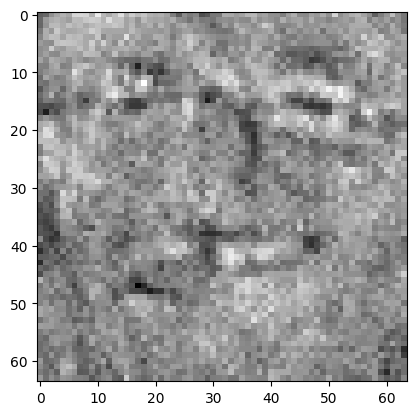

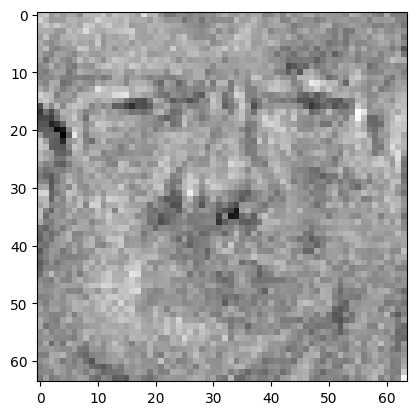

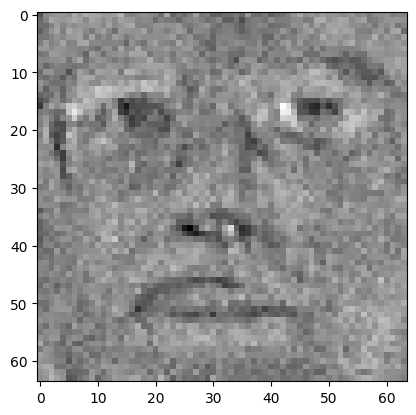

Epoch 362 : 


100%|██████████| 400/400 [00:20<00:00, 19.84it/s]


loss 0.26709962602016574
Epoch 363 : 


100%|██████████| 400/400 [00:19<00:00, 20.07it/s]


loss 0.19078858914979846
Epoch 364 : 


100%|██████████| 400/400 [00:19<00:00, 20.27it/s]


loss 0.22627500965943492
Epoch 365 : 


100%|██████████| 400/400 [00:19<00:00, 20.13it/s]


loss 0.19723640573686302
Epoch 366 : 


100%|██████████| 400/400 [00:19<00:00, 20.24it/s]


loss 0.20238767763948473
Epoch 367 : 


100%|██████████| 400/400 [00:21<00:00, 19.02it/s]


loss 0.20371171238570812
Epoch 368 : 


100%|██████████| 400/400 [00:19<00:00, 20.30it/s]


loss 0.17836703249189237
Epoch 369 : 


100%|██████████| 400/400 [00:19<00:00, 20.13it/s]


loss 0.1879059869087236
Epoch 370 : 


100%|██████████| 400/400 [00:19<00:00, 20.07it/s]


loss 0.2545501710957661
Epoch 371 : 


100%|██████████| 400/400 [00:19<00:00, 20.36it/s]


loss 0.1574132835754545
Epoch 372 : 


100%|██████████| 400/400 [00:18<00:00, 21.59it/s]


loss 0.1897774201875877
Epoch 373 : 


100%|██████████| 400/400 [00:19<00:00, 20.39it/s]


loss 0.1854678451101362
Epoch 374 : 


100%|██████████| 400/400 [00:20<00:00, 19.68it/s]


loss 0.21609105165391612
Epoch 375 : 


100%|██████████| 400/400 [00:19<00:00, 20.15it/s]


loss 0.23710955467071407
Epoch 376 : 


100%|██████████| 400/400 [00:19<00:00, 20.56it/s]


loss 0.2842877784463138
Epoch 377 : 


100%|██████████| 400/400 [00:19<00:00, 20.43it/s]


loss 0.2323227311171645
Epoch 378 : 


100%|██████████| 400/400 [00:19<00:00, 20.27it/s]


loss 0.22861284353313285
Epoch 379 : 


100%|██████████| 400/400 [00:21<00:00, 19.00it/s]


loss 0.15344351155845973
Epoch 380 : 


100%|██████████| 400/400 [00:20<00:00, 19.82it/s]


loss 0.18594429621296196
Epoch 381 : 


100%|██████████| 400/400 [00:19<00:00, 20.70it/s]


loss 0.14792951874603807
torch.Size([3, 1, 64, 64])


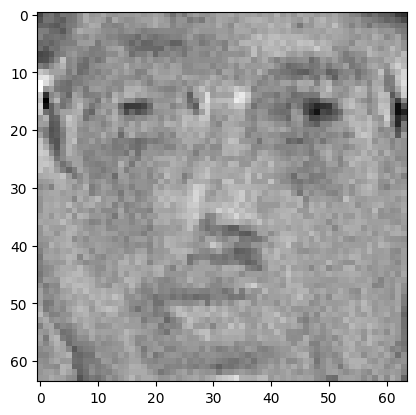

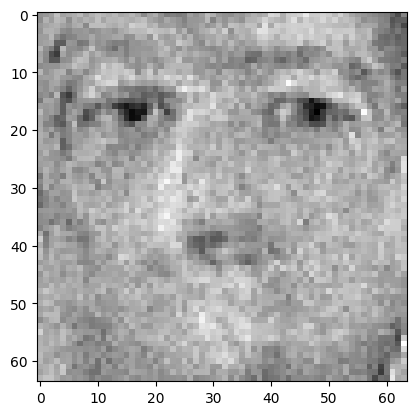

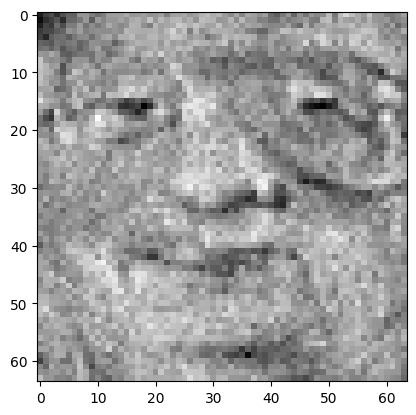

Epoch 382 : 


100%|██████████| 400/400 [00:19<00:00, 20.70it/s]


loss 0.27434074096352623
Epoch 383 : 


100%|██████████| 400/400 [00:20<00:00, 19.51it/s]


loss 0.18547149194420692
Epoch 384 : 


100%|██████████| 400/400 [00:19<00:00, 20.18it/s]


loss 0.18958766067507407
Epoch 385 : 


100%|██████████| 400/400 [00:19<00:00, 20.39it/s]


loss 0.18679804222259622
Epoch 386 : 


100%|██████████| 400/400 [00:19<00:00, 21.00it/s]


loss 0.2610915720901813
Epoch 387 : 


100%|██████████| 400/400 [00:20<00:00, 19.97it/s]


loss 0.2602234311455833
Epoch 388 : 


100%|██████████| 400/400 [00:19<00:00, 20.38it/s]


loss 0.16155016322892904
Epoch 389 : 


100%|██████████| 400/400 [00:19<00:00, 20.43it/s]


loss 0.18496325642251607
Epoch 390 : 


100%|██████████| 400/400 [00:19<00:00, 20.63it/s]


loss 0.20883359550816497
Epoch 391 : 


100%|██████████| 400/400 [00:19<00:00, 20.43it/s]


loss 0.16123763114862785
Epoch 392 : 


100%|██████████| 400/400 [00:20<00:00, 19.64it/s]


loss 0.27381596122629537
Epoch 393 : 


100%|██████████| 400/400 [00:19<00:00, 20.61it/s]


loss 0.15513220332080024
Epoch 394 : 


100%|██████████| 400/400 [00:18<00:00, 21.11it/s]


loss 0.1764879511166424
Epoch 395 : 


100%|██████████| 400/400 [00:19<00:00, 20.25it/s]


loss 0.20726025646691057
Epoch 396 : 


100%|██████████| 400/400 [00:18<00:00, 21.14it/s]


loss 0.18495413552395876
Epoch 397 : 


100%|██████████| 400/400 [00:19<00:00, 20.21it/s]


loss 0.17943313139514336
Epoch 398 : 


100%|██████████| 400/400 [00:19<00:00, 20.91it/s]


loss 0.2914783906489828
Epoch 399 : 


100%|██████████| 400/400 [00:19<00:00, 21.05it/s]


loss 0.1741921931749933
Epoch 400 : 


100%|██████████| 400/400 [00:19<00:00, 21.04it/s]


loss 0.19155782547690522
Epoch 401 : 


100%|██████████| 400/400 [00:19<00:00, 20.27it/s]


loss 0.12493025286938605
torch.Size([3, 1, 64, 64])


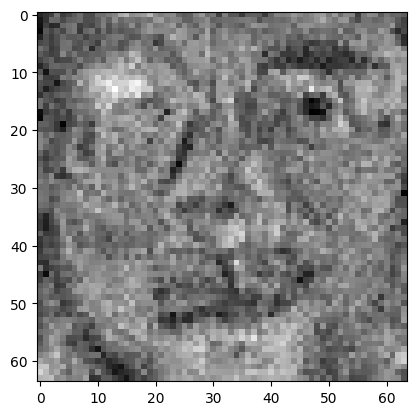

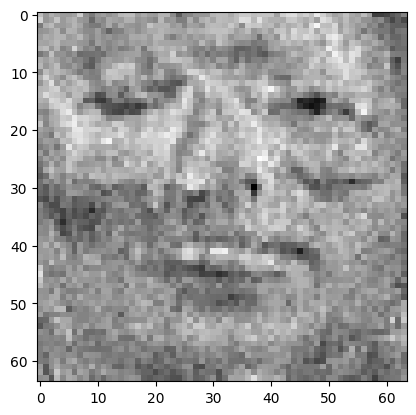

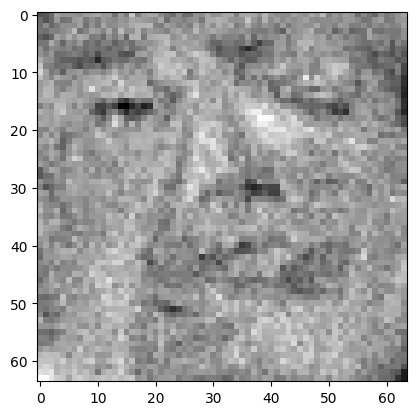

Epoch 402 : 


100%|██████████| 400/400 [00:20<00:00, 19.94it/s]


loss 0.2686629346263883
Epoch 403 : 


100%|██████████| 400/400 [00:20<00:00, 19.87it/s]


loss 0.17916595470942132
Epoch 404 : 


100%|██████████| 400/400 [00:19<00:00, 20.83it/s]


loss 0.22830357407364116
Epoch 405 : 


100%|██████████| 400/400 [00:20<00:00, 19.64it/s]


loss 0.2212561954125072
Epoch 406 : 


100%|██████████| 400/400 [00:19<00:00, 20.40it/s]


loss 0.13775642239699673
Epoch 407 : 


100%|██████████| 400/400 [00:18<00:00, 21.16it/s]


loss 0.15085867066950293
Epoch 408 : 


100%|██████████| 400/400 [00:19<00:00, 21.03it/s]


loss 0.21331516667067543
Epoch 409 : 


100%|██████████| 400/400 [00:19<00:00, 20.43it/s]


loss 0.1656689866774582
Epoch 410 : 


100%|██████████| 400/400 [00:20<00:00, 19.62it/s]


loss 0.23291518698200783
Epoch 411 : 


100%|██████████| 400/400 [00:19<00:00, 20.54it/s]


loss 0.2857400213901348
Epoch 412 : 


100%|██████████| 400/400 [00:19<00:00, 20.81it/s]


loss 0.21657109905309044
Epoch 413 : 


100%|██████████| 400/400 [00:18<00:00, 21.10it/s]


loss 0.21630983292896414
Epoch 414 : 


100%|██████████| 400/400 [00:19<00:00, 20.32it/s]


loss 0.18659688722020604
Epoch 415 : 


100%|██████████| 400/400 [00:19<00:00, 20.79it/s]


loss 0.16760314118097805
Epoch 416 : 


100%|██████████| 400/400 [00:19<00:00, 20.48it/s]


loss 0.17525139778681825
Epoch 417 : 


100%|██████████| 400/400 [00:19<00:00, 20.79it/s]


loss 0.14622420273863573
Epoch 418 : 


100%|██████████| 400/400 [00:20<00:00, 19.96it/s]


loss 0.21918807550740046
Epoch 419 : 


100%|██████████| 400/400 [00:20<00:00, 19.68it/s]


loss 0.23422487392472252
Epoch 420 : 


100%|██████████| 400/400 [00:20<00:00, 19.36it/s]


loss 0.14811226299981636
Epoch 421 : 


100%|██████████| 400/400 [00:19<00:00, 20.37it/s]


loss 0.18145307967504637
torch.Size([3, 1, 64, 64])


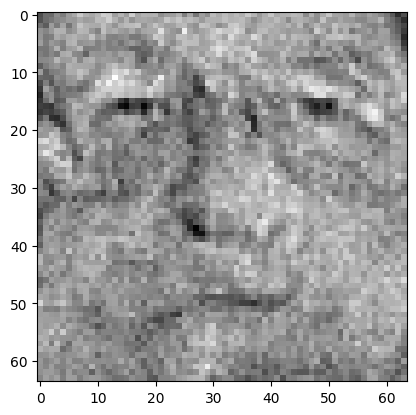

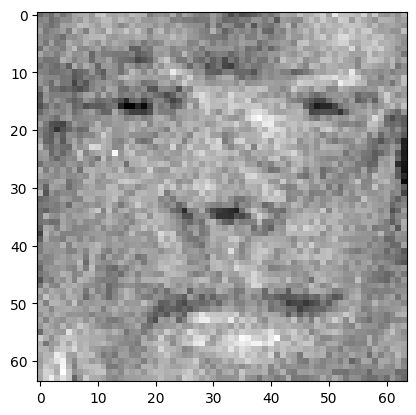

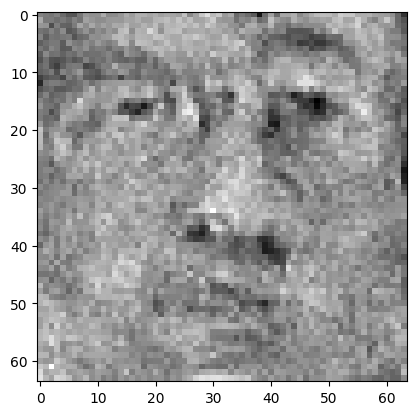

Epoch 422 : 


100%|██████████| 400/400 [00:19<00:00, 20.34it/s]


loss 0.1428308022294596
Epoch 423 : 


100%|██████████| 400/400 [00:20<00:00, 19.54it/s]


loss 0.2032354273973429
Epoch 424 : 


100%|██████████| 400/400 [00:20<00:00, 19.75it/s]


loss 0.16381516174685062
Epoch 425 : 


100%|██████████| 400/400 [00:19<00:00, 20.22it/s]


loss 0.19605148723871674
Epoch 426 : 


100%|██████████| 400/400 [00:20<00:00, 19.97it/s]


loss 0.16413463028764322
Epoch 427 : 


100%|██████████| 400/400 [00:20<00:00, 19.38it/s]


loss 0.31773978565871297
Epoch 428 : 


100%|██████████| 400/400 [00:19<00:00, 20.45it/s]


loss 0.15348681253230623
Epoch 429 : 


100%|██████████| 400/400 [00:19<00:00, 20.18it/s]


loss 0.2161598074959143
Epoch 430 : 


100%|██████████| 400/400 [00:19<00:00, 20.29it/s]


loss 0.22388002396840623
Epoch 431 : 


100%|██████████| 400/400 [00:20<00:00, 19.44it/s]


loss 0.3895753860648107
Epoch 432 : 


100%|██████████| 400/400 [00:19<00:00, 20.65it/s]


loss 0.16943874021420666
Epoch 433 : 


100%|██████████| 400/400 [00:19<00:00, 20.28it/s]


loss 0.22536957066223884
Epoch 434 : 


100%|██████████| 400/400 [00:19<00:00, 20.03it/s]


loss 0.26220587683472496
Epoch 435 : 


100%|██████████| 400/400 [00:19<00:00, 20.94it/s]


loss 0.1532216810659645
Epoch 436 : 


100%|██████████| 400/400 [00:19<00:00, 20.89it/s]


loss 0.18224890847172223
Epoch 437 : 


100%|██████████| 400/400 [00:19<00:00, 20.76it/s]


loss 0.22333853258642336
Epoch 438 : 


100%|██████████| 400/400 [00:20<00:00, 19.94it/s]


loss 0.17359722398219476
Epoch 439 : 


100%|██████████| 400/400 [00:19<00:00, 20.05it/s]


loss 0.20059249312053792
Epoch 440 : 


100%|██████████| 400/400 [00:19<00:00, 20.09it/s]


loss 0.1754031238038762
Epoch 441 : 


100%|██████████| 400/400 [00:19<00:00, 20.37it/s]


loss 0.17796409007233852
torch.Size([3, 1, 64, 64])


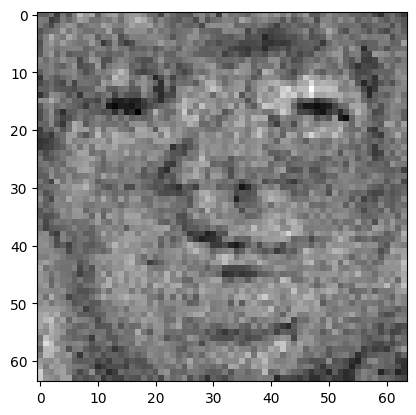

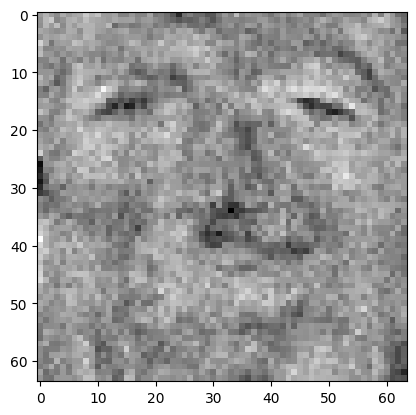

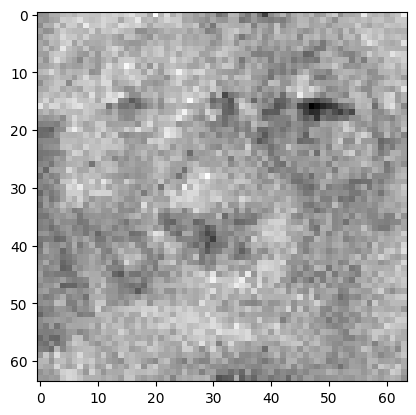

Epoch 442 : 


100%|██████████| 400/400 [00:20<00:00, 19.72it/s]


loss 0.21305517286320586
Epoch 443 : 


100%|██████████| 400/400 [00:19<00:00, 20.51it/s]


loss 0.20246423971100067
Epoch 444 : 


100%|██████████| 400/400 [00:19<00:00, 20.31it/s]


loss 0.1324793131299464
Epoch 445 : 


100%|██████████| 400/400 [00:20<00:00, 19.79it/s]


loss 0.16295852258637944
Epoch 446 : 


100%|██████████| 400/400 [00:20<00:00, 19.85it/s]


loss 0.16453756306252768
Epoch 447 : 


100%|██████████| 400/400 [00:19<00:00, 20.55it/s]


loss 0.28331959785483946
Epoch 448 : 


100%|██████████| 400/400 [00:20<00:00, 19.51it/s]


loss 0.24892486122851384
Epoch 449 : 


100%|██████████| 400/400 [00:19<00:00, 20.60it/s]


loss 0.23773542967724676
Epoch 450 : 


100%|██████████| 400/400 [00:18<00:00, 21.11it/s]


loss 0.18207728369442922
Epoch 451 : 


100%|██████████| 400/400 [00:20<00:00, 20.00it/s]


loss 0.22942355932113892
Epoch 452 : 


100%|██████████| 400/400 [00:19<00:00, 20.56it/s]


loss 0.23592404124895092
Epoch 453 : 


100%|██████████| 400/400 [00:19<00:00, 20.37it/s]


loss 0.15866457708838533
Epoch 454 : 


100%|██████████| 400/400 [00:18<00:00, 21.19it/s]


loss 0.24992988670541536
Epoch 455 : 


100%|██████████| 400/400 [00:19<00:00, 20.51it/s]


loss 0.1880259871745822
Epoch 456 : 


100%|██████████| 400/400 [00:20<00:00, 19.82it/s]


loss 0.15129053273854906
Epoch 457 : 


100%|██████████| 400/400 [00:19<00:00, 20.61it/s]


loss 0.16629129073586688
Epoch 458 : 


100%|██████████| 400/400 [00:19<00:00, 20.64it/s]


loss 0.2043212118537317
Epoch 459 : 


100%|██████████| 400/400 [00:20<00:00, 19.80it/s]


loss 0.2385637705672879
Epoch 460 : 


100%|██████████| 400/400 [00:20<00:00, 19.85it/s]


loss 0.1740704301990104
Epoch 461 : 


100%|██████████| 400/400 [00:19<00:00, 20.06it/s]


loss 0.16612941715412166
torch.Size([3, 1, 64, 64])


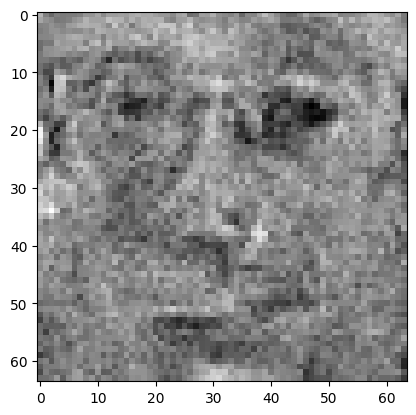

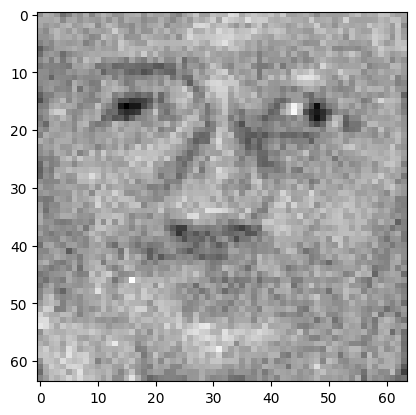

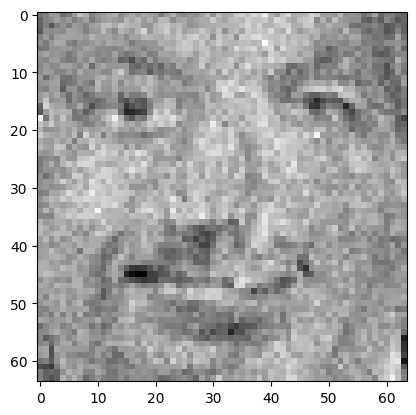

Epoch 462 : 


100%|██████████| 400/400 [00:20<00:00, 19.78it/s]


loss 0.19124223808565285
Epoch 463 : 


100%|██████████| 400/400 [00:19<00:00, 20.61it/s]


loss 0.1970317906830265
Epoch 464 : 


100%|██████████| 400/400 [00:20<00:00, 19.68it/s]


loss 0.19828895441563324
Epoch 465 : 


100%|██████████| 400/400 [00:19<00:00, 20.78it/s]


loss 0.2228561893252988
Epoch 466 : 


100%|██████████| 400/400 [00:20<00:00, 19.91it/s]


loss 0.25326381544486104
Epoch 467 : 


100%|██████████| 400/400 [00:19<00:00, 20.29it/s]


loss 0.25692306193724207
Epoch 468 : 


100%|██████████| 400/400 [00:20<00:00, 19.90it/s]


loss 0.216078770619543
Epoch 469 : 


100%|██████████| 400/400 [00:20<00:00, 19.87it/s]


loss 0.18195943853014268
Epoch 470 : 


100%|██████████| 400/400 [00:20<00:00, 19.93it/s]


loss 0.16006497433401096
Epoch 471 : 


100%|██████████| 400/400 [00:19<00:00, 20.51it/s]


loss 0.16167440671383657
Epoch 472 : 


100%|██████████| 400/400 [00:19<00:00, 20.70it/s]


loss 0.19220419835814023
Epoch 473 : 


100%|██████████| 400/400 [00:20<00:00, 19.78it/s]


loss 0.21866037278285158
Epoch 474 : 


100%|██████████| 400/400 [00:19<00:00, 20.22it/s]


loss 0.17048091628157558
Epoch 475 : 


100%|██████████| 400/400 [00:20<00:00, 19.37it/s]


loss 0.17083529860204089
Epoch 476 : 


100%|██████████| 400/400 [00:19<00:00, 20.21it/s]


loss 0.1777980938379765
Epoch 477 : 


100%|██████████| 400/400 [00:20<00:00, 20.00it/s]


loss 0.280864547453786
Epoch 478 : 


100%|██████████| 400/400 [00:19<00:00, 20.92it/s]


loss 0.2086943837211513
Epoch 479 : 


100%|██████████| 400/400 [00:20<00:00, 19.21it/s]


loss 0.17876146806628132
Epoch 480 : 


100%|██████████| 400/400 [00:20<00:00, 19.48it/s]


loss 0.22120713793639757
Epoch 481 : 


100%|██████████| 400/400 [00:19<00:00, 20.23it/s]


loss 0.16312483697081448
torch.Size([3, 1, 64, 64])


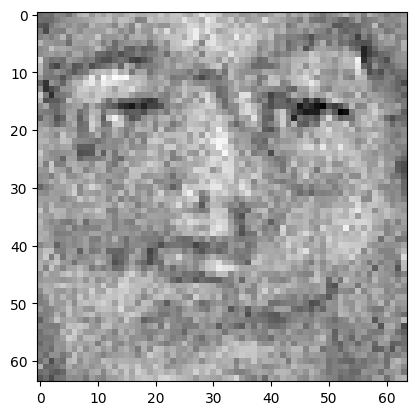

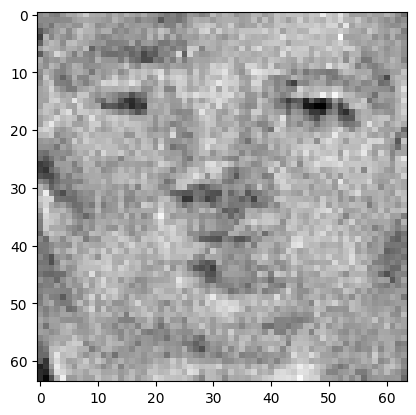

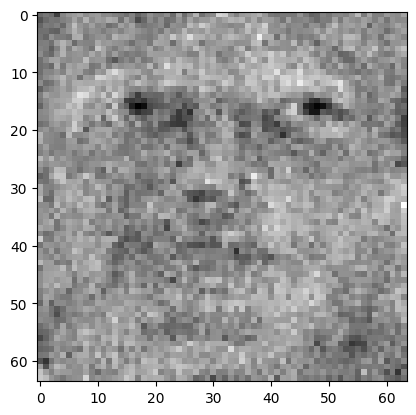

Epoch 482 : 


100%|██████████| 400/400 [00:20<00:00, 19.26it/s]


loss 0.20325137227955659
Epoch 483 : 


100%|██████████| 400/400 [00:19<00:00, 20.36it/s]


loss 0.25673632525020584
Epoch 484 : 


100%|██████████| 400/400 [00:19<00:00, 20.95it/s]


loss 0.23429289777755313
Epoch 485 : 


100%|██████████| 400/400 [00:19<00:00, 20.05it/s]


loss 0.12853119015740833
Epoch 486 : 


100%|██████████| 400/400 [00:19<00:00, 20.60it/s]


loss 0.27139752463611033
Epoch 487 : 


100%|██████████| 400/400 [00:20<00:00, 19.88it/s]


loss 0.1700900643430729
Epoch 488 : 


100%|██████████| 400/400 [00:19<00:00, 20.30it/s]


loss 0.18833378814403387
Epoch 489 : 


100%|██████████| 400/400 [00:20<00:00, 19.84it/s]


loss 0.20799265750044382
Epoch 490 : 


100%|██████████| 400/400 [00:19<00:00, 20.13it/s]


loss 0.14950193136886458
Epoch 491 : 


100%|██████████| 400/400 [00:19<00:00, 20.67it/s]


loss 0.14928642756459784
Epoch 492 : 


100%|██████████| 400/400 [00:19<00:00, 20.54it/s]


loss 0.21306323448373005
Epoch 493 : 


100%|██████████| 400/400 [00:19<00:00, 20.05it/s]


loss 0.22878993835671305
Epoch 494 : 


100%|██████████| 400/400 [00:19<00:00, 20.66it/s]


loss 0.2481392792641252
Epoch 495 : 


100%|██████████| 400/400 [00:19<00:00, 20.26it/s]


loss 0.18461310815705587
Epoch 496 : 


100%|██████████| 400/400 [00:19<00:00, 20.34it/s]


loss 0.18104206968374753
Epoch 497 : 


100%|██████████| 400/400 [00:20<00:00, 19.80it/s]


loss 0.14747873040737958
Epoch 498 : 


100%|██████████| 400/400 [00:20<00:00, 19.96it/s]


loss 0.2444929316524927
Epoch 499 : 


100%|██████████| 400/400 [00:19<00:00, 21.04it/s]


loss 0.1730236021061904


In [15]:
train_ddpm(500, 0.0001, 1, 0.0000)